In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

import re
import json
import time

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

import pickle
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from wordcloud import WordCloud
from collections import Counter

In [2]:
df = pd.read_csv('./OPTION2_joined_coursework_dataset_banking_final.csv')

In [3]:
df

,text,label,query_index
0,Can I automatically top-up when traveling?,top_up_queries_or_issues,526cd7f17526
1,What kind of fiat currency can I used for hold...,other,f3cf7343067e
2,I did not get the item I ordered. How should ...,other,9a19501c3a3c
3,Freeze my account it's been hacked.,needs_troubleshooting,d76b07db8cf8
4,is there a reason that my payment didnt go thr...,other,bd95ba09a18d
...,...,...,...
14190,Can you tell me what the disposable cards are ...,card_queries_or_issues,bd6df98cc746
14191,The ATM won't give me my card back. I need it ...,card_queries_or_issues,e6197a1334b3
14192,Can you please tell me why my card payments ar...,card_queries_or_issues,b922a2a5f687
14193,The rate for a currency exchange was wrong whe...,needs_troubleshooting,cb1ed2c3ca95


In [4]:
df.shape

(14195, 3)

In [5]:
df.columns

Index(['text', 'label', 'query_index'], dtype='object')

In [6]:
df['label'].value_counts()

other                       5036
needs_troubleshooting       4305
card_queries_or_issues      2598
top_up_queries_or_issues    1684
Other                         21
Card_queries_or_issues        12
Top_up_queries_or_issues      11
Needs_troubleshooting          7
Name: label, dtype: int64

### We have to transform into 4 classes in total “card queries or issues”, “needs troubleshooting”, “top up queries or issues”, “other” 

In [7]:
df['label'] = df['label'].str.lower()

In [8]:
df['label'].value_counts()

other                       5057
needs_troubleshooting       4312
card_queries_or_issues      2610
top_up_queries_or_issues    1695
Name: label, dtype: int64

In [9]:
pd.DataFrame(df['text'].value_counts())

,text
#,68
I topped up but the app did not accept it.,3
How do I know if my top up was unsuccessful?,3
"Oh my goodness, my card has been declined twice at ATM! I tried two different ATM, but each one declined my card! Can you tell me what's going on with my account?",3
I don't understand where this debit came from and want it removed.,3
...,...
My statement shows different transaction times.,1
What are the steps I need to take to cancel a transaction?,1
after i got married i need to change my name,1
I still have not received an answer as to why I was charged $1.00 in a transaction?,1


In [10]:
df[df['text'] == '#']['label'] = df[df['text'] == '#']['label'].value_counts().idxmax()

In [11]:
highest_count = df[df['text'] == '#']['label'].value_counts().idxmax()
df.loc[df['text'] == '#', 'label'] = highest_count

## Dealing with Null Values

In [12]:
df.isna().sum()

text             0
label          521
query_index      0
dtype: int64

In [13]:
df[df['label'].isna()]

,text,label,query_index
17,What do you charge to top up US cards?,NaN,f9ct7333337b
22,I did a transfer to my account but it doesn't ...,NaN,a85ta60fdb59
43,I'm not recognizing the card payment.,NaN,f55t70c7ee03
52,Is it okay to use a bank card to top up,NaN,c72t8fdedfc9
99,Why is there an extra fee on my statement?,NaN,ee0t3820e035
...,...,...,...
14131,When did you start charging to make a withdraw...,NaN,8c8t86b69685
14140,Is there a fee to add money to an internationa...,NaN,f1dt07d4aad8
14155,My money transaction hasn't arrived.,NaN,2b4td3854067
14177,I want to get some cash from the ATM using my ...,NaN,0fdtb1ed8321


In [14]:
df[df['text'] == 'What do you charge to top up US cards?']

,text,label,query_index
17,What do you charge to top up US cards?,NaN,f9ct7333337b
7924,What do you charge to top up US cards?,top_up_queries_or_issues,f9c07333337b


In [15]:
text_duplicates = df[df.duplicated(subset=['text'], keep=False)]

In [16]:
text_duplicates

,text,label,query_index
17,What do you charge to top up US cards?,NaN,f9ct7333337b
22,I did a transfer to my account but it doesn't ...,NaN,a85ta60fdb59
31,Is there a charge for exchanging foreign curre...,other,a3868d3af8da
39,Hello I made a bank transfer couple hours ago ...,needs_troubleshooting,1612042a2d27
43,I'm not recognizing the card payment.,NaN,f55t70c7ee03
...,...,...,...
14171,Someone else used my card!,needs_troubleshooting,4a9ac2ff2976
14174,Why was money taken for a transfer?,other,62ff235434bf
14177,I want to get some cash from the ATM using my ...,NaN,0fdtb1ed8321
14188,My transfer was declined. What might the reaso...,NaN,aeet3c64060d


In [17]:
sorted_text_duplicates = text_duplicates.sort_values(by=['text'])

In [18]:
sorted_text_duplicates

,text,label,query_index
11294,\nDo I need to go to a physical bank to change...,other,bd266914309f
12851,\nDo I need to go to a physical bank to change...,other,bd266914309f
12814,\nWhere can I use my card?,card_queries_or_issues,8c5e2792341b
4211,\nWhere can I use my card?,card_queries_or_issues,8c5e2792341b
2679,#,other,83dt36353408
...,...,...,...
12077,why isnt my cash withdrawal showing,other,d8be9d199edb
9691,why top up is not working even if I got my Ame...,NaN,251t19d88274
4683,why top up is not working even if I got my Ame...,other,251719d88274
3150,why wasn't a transfer to account approved,NaN,791tec873502


In [19]:
sorted_text_duplicates.isna().sum()

text             0
label          521
query_index      0
dtype: int64

In [20]:
# There are text columns that are duplicated but having the label values as NaN
# So the next step is to fill the NaN values with the corresponding label group value

In [21]:
df['label'] = df.groupby('text')['label'].apply(lambda x: x.fillna(x.mode()[0]))

In [22]:
text_duplicates = df[df.duplicated(subset=['text'], keep=False)]
sorted_text_duplicates = text_duplicates.sort_values(by=['text'])
sorted_text_duplicates

,text,label,query_index
11294,\nDo I need to go to a physical bank to change...,other,bd266914309f
12851,\nDo I need to go to a physical bank to change...,other,bd266914309f
12814,\nWhere can I use my card?,card_queries_or_issues,8c5e2792341b
4211,\nWhere can I use my card?,card_queries_or_issues,8c5e2792341b
2679,#,other,83dt36353408
...,...,...,...
12077,why isnt my cash withdrawal showing,other,d8be9d199edb
9691,why top up is not working even if I got my Ame...,other,251t19d88274
4683,why top up is not working even if I got my Ame...,other,251719d88274
3150,why wasn't a transfer to account approved,needs_troubleshooting,791tec873502


In [23]:
sorted_text_duplicates.isna().sum()

text           0
label          0
query_index    0
dtype: int64

In [24]:
df.isna().sum()

text           0
label          0
query_index    0
dtype: int64

In [25]:
df.drop_duplicates(subset=["text"],keep="first",inplace=True)

In [26]:
df.shape

(13084, 3)

In [27]:
df['query_index'].value_counts()

526cd7f17526    1
be7f630d23e6    1
c76d0689bc38    1
7b7132a101a3    1
048df7723d23    1
               ..
c2ff064df31a    1
1b5c41964834    1
57be586d1da7    1
c5e8492cfaf5    1
f7e5a9b88449    1
Name: query_index, Length: 13084, dtype: int64

In [28]:
(df['query_index'].value_counts() > 0).sum()

13084

In [29]:
df.drop(['query_index'], axis=1, inplace=True)

In [30]:
df

,text,label
0,Can I automatically top-up when traveling?,top_up_queries_or_issues
1,What kind of fiat currency can I used for hold...,other
2,I did not get the item I ordered. How should ...,other
3,Freeze my account it's been hacked.,needs_troubleshooting
4,is there a reason that my payment didnt go thr...,other
...,...,...
14190,Can you tell me what the disposable cards are ...,card_queries_or_issues
14191,The ATM won't give me my card back. I need it ...,card_queries_or_issues
14192,Can you please tell me why my card payments ar...,card_queries_or_issues
14193,The rate for a currency exchange was wrong whe...,needs_troubleshooting


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13084 entries, 0 to 14194
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    13084 non-null  object
 1   label   13084 non-null  object
dtypes: object(2)
memory usage: 306.7+ KB


In [32]:
df.head()

,text,label
0,Can I automatically top-up when traveling?,top_up_queries_or_issues
1,What kind of fiat currency can I used for hold...,other
2,I did not get the item I ordered. How should ...,other
3,Freeze my account it's been hacked.,needs_troubleshooting
4,is there a reason that my payment didnt go thr...,other


In [33]:
df.describe()

,text,label
count,13084,13084
unique,13084,4
top,Can I automatically top-up when traveling?,other
freq,1,4804


In [34]:
pd.DataFrame(df['text'].value_counts())

,text
Can I automatically top-up when traveling?,1
I was charged for a cash withdrawal.,1
"I asked for $40 and I only received $20, what happened?",1
"Can you tell me how long it would take, to make a transfer from France? I made one 2 days ago and its not there yet.",1
I want to reverse a transaction I did this morning,1
...,...
Are there fees for adding money using an international card,1
"The card I thought I lost was in my jacket pocket this morning, so can I reactivate that?",1
What types of foreign money can be used with this service.?,1
I have transfered to my account before but it is being declined now?,1


In [35]:
df

,text,label
0,Can I automatically top-up when traveling?,top_up_queries_or_issues
1,What kind of fiat currency can I used for hold...,other
2,I did not get the item I ordered. How should ...,other
3,Freeze my account it's been hacked.,needs_troubleshooting
4,is there a reason that my payment didnt go thr...,other
...,...,...
14190,Can you tell me what the disposable cards are ...,card_queries_or_issues
14191,The ATM won't give me my card back. I need it ...,card_queries_or_issues
14192,Can you please tell me why my card payments ar...,card_queries_or_issues
14193,The rate for a currency exchange was wrong whe...,needs_troubleshooting


# Exploratory Data Analysis [ EDA ]

In [36]:
df1 = df.copy()

In [37]:
df1

,text,label
0,Can I automatically top-up when traveling?,top_up_queries_or_issues
1,What kind of fiat currency can I used for hold...,other
2,I did not get the item I ordered. How should ...,other
3,Freeze my account it's been hacked.,needs_troubleshooting
4,is there a reason that my payment didnt go thr...,other
...,...,...
14190,Can you tell me what the disposable cards are ...,card_queries_or_issues
14191,The ATM won't give me my card back. I need it ...,card_queries_or_issues
14192,Can you please tell me why my card payments ar...,card_queries_or_issues
14193,The rate for a currency exchange was wrong whe...,needs_troubleshooting


In [38]:
df1.shape

(13084, 2)

### Label Distribution

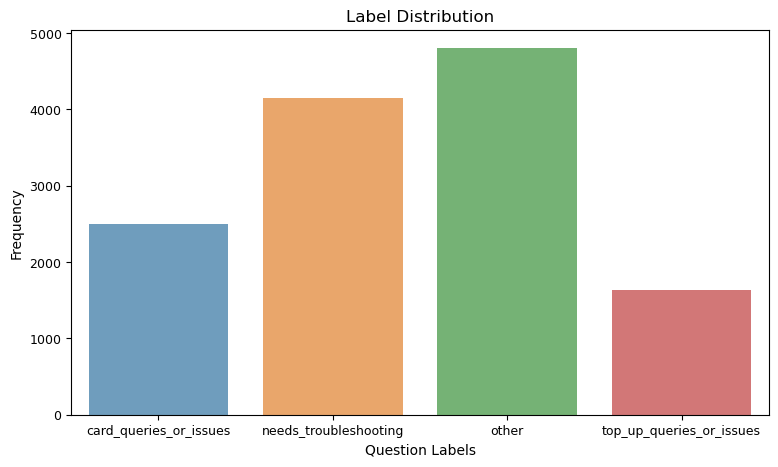

In [39]:
x_label = df1['label'].value_counts()
y_count = x_label.sort_index()
plt.figure(figsize=(9,5))
sns.barplot(x=y_count.index, y=y_count.values, alpha=0.7)
plt.title("Label Distribution", fontsize=12)
plt.ylabel('Frequency', fontsize=10)
plt.yticks(fontsize=9)
plt.xlabel('Question Labels', fontsize=10)
plt.xticks(fontsize=9, rotation=0)
plt.show()

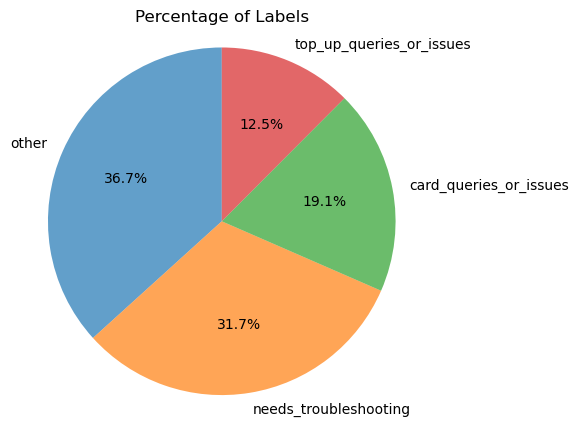

In [40]:
x_label = df1['label'].value_counts()
plt.figure(figsize=(5, 5))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
alpha = 0.7
transparent_colors = [(r, g, b, alpha) for r, g, b in plt.cm.tab10.colors]
plt.pie(x_label.values, labels=x_label.index, autopct='%1.1f%%', startangle=90, colors=transparent_colors)
plt.title('Percentage of Labels')
plt.axis('equal')
plt.show()

### Avg. Number of Words per Label

In [41]:
df1['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

In [42]:
df1

,text,label,word_count
0,Can I automatically top-up when traveling?,top_up_queries_or_issues,6
1,What kind of fiat currency can I used for hold...,other,12
2,I did not get the item I ordered. How should ...,other,26
3,Freeze my account it's been hacked.,needs_troubleshooting,6
4,is there a reason that my payment didnt go thr...,other,10
...,...,...,...
14190,Can you tell me what the disposable cards are ...,card_queries_or_issues,11
14191,The ATM won't give me my card back. I need it ...,card_queries_or_issues,13
14192,Can you please tell me why my card payments ar...,card_queries_or_issues,37
14193,The rate for a currency exchange was wrong whe...,needs_troubleshooting,12


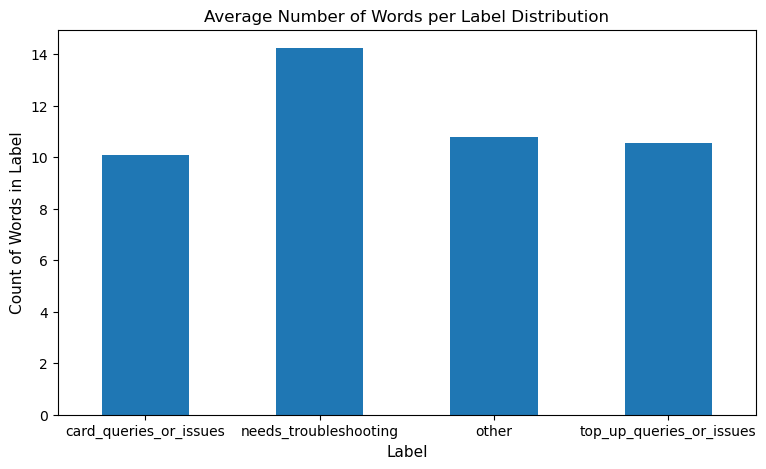

In [43]:
word_avg = df1.groupby('label')['word_count'].mean().plot(kind='bar', figsize=(9,5))
plt.xlabel('Label', fontsize=11)
plt.ylabel('Count of Words in Label', fontsize=11)
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.title('Average Number of Words per Label Distribution', fontsize=12)
plt.show()

# Data Preprocessing

In [44]:
def preprocess_text(text, use_stemming=False, use_lemmatization=True):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub('[^a-zA-Z\s]', '', text)
    text = re.sub('\d+', '', text)

    # Tokenize text
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Apply stemming and/or lemmatization
    if use_stemming:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]

    if use_lemmatization:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

    # Join words back into a string
    text = ' '.join(words)

    return text


In [45]:
df['text'] = df['text'].apply(preprocess_text)

In [46]:
df

,text,label
0,automatically topup traveling,top_up_queries_or_issues
1,kind fiat currency used holding exchange,other
2,get item ordered go cancel order payment pleas...,other
3,freeze account hacked,needs_troubleshooting
4,reason payment didnt go,other
...,...,...
14190,tell disposable card used,card_queries_or_issues
14191,atm wont give card back need back,card_queries_or_issues
14192,please tell card payment going try buy somethi...,card_queries_or_issues
14193,rate currency exchange wrong bought something,needs_troubleshooting


In [47]:
# Saving the preprocessed dataset.
df.to_csv('final_df.csv')

### Word Frequency Analysis after Stop Word Removal and Preprocessing

In [48]:
text_df = df['text']
all_words = []
for wordlist in text_df:
    for word in wordlist.split():
        all_words.append(word)

In [49]:
unique_labels = df['label'].unique()
print(unique_labels)

['top_up_queries_or_issues' 'other' 'needs_troubleshooting'
 'card_queries_or_issues']


In [50]:
df

,text,label
0,automatically topup traveling,top_up_queries_or_issues
1,kind fiat currency used holding exchange,other
2,get item ordered go cancel order payment pleas...,other
3,freeze account hacked,needs_troubleshooting
4,reason payment didnt go,other
...,...,...
14190,tell disposable card used,card_queries_or_issues
14191,atm wont give card back need back,card_queries_or_issues
14192,please tell card payment going try buy somethi...,card_queries_or_issues
14193,rate currency exchange wrong bought something,needs_troubleshooting


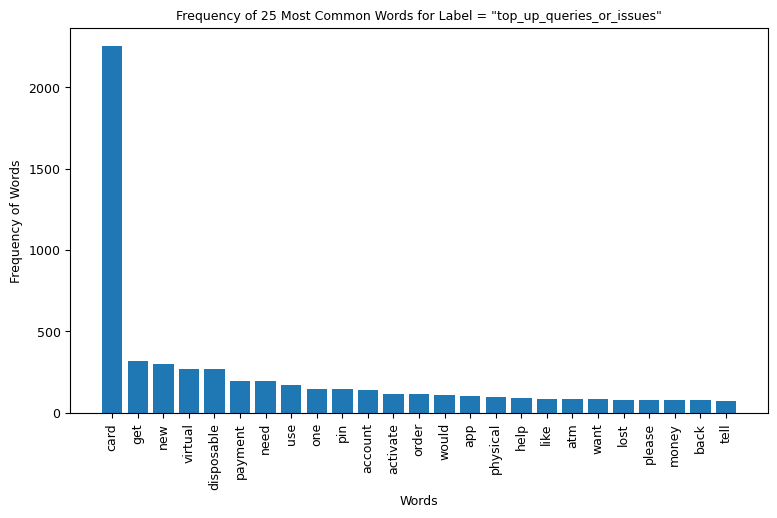

In [51]:
group_by = df.groupby('label')['text'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_tag = group_by.iloc[0]
words0 = list(zip(*group_by_tag))[0]
freq0 = list(zip(*group_by_tag))[1]
plt.figure(figsize=(9,5))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=9)
plt.ylabel('Frequency of Words', fontsize=9)
plt.yticks(fontsize=9)
plt.xticks(rotation=90, fontsize=9)
plt.title(f'Frequency of 25 Most Common Words for Label = "{unique_labels[0]}"', fontsize=9)
plt.show()

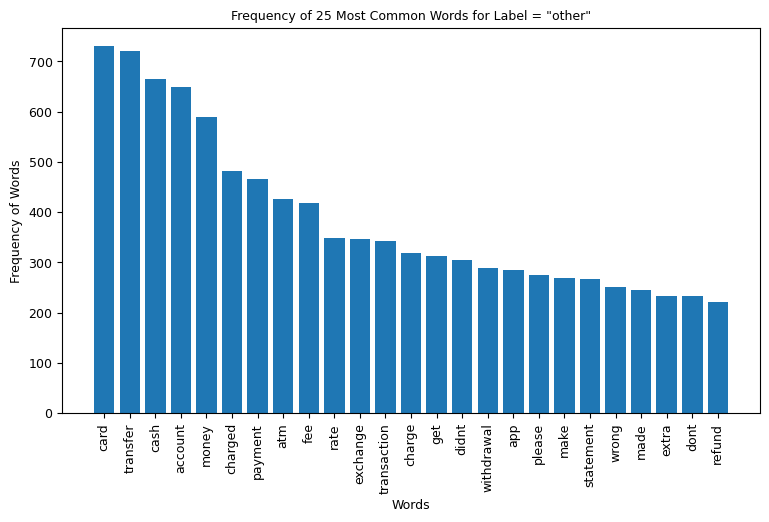

In [52]:
group_by = df.groupby('label')['text'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_tag = group_by.iloc[1]
words0 = list(zip(*group_by_tag))[0]
freq0 = list(zip(*group_by_tag))[1]
plt.figure(figsize=(9,5))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=9)
plt.ylabel('Frequency of Words', fontsize=9)
plt.yticks(fontsize=9)
plt.xticks(rotation=90, fontsize=9)
plt.title(f'Frequency of 25 Most Common Words for Label = "{unique_labels[1]}"', fontsize=9)
plt.show()

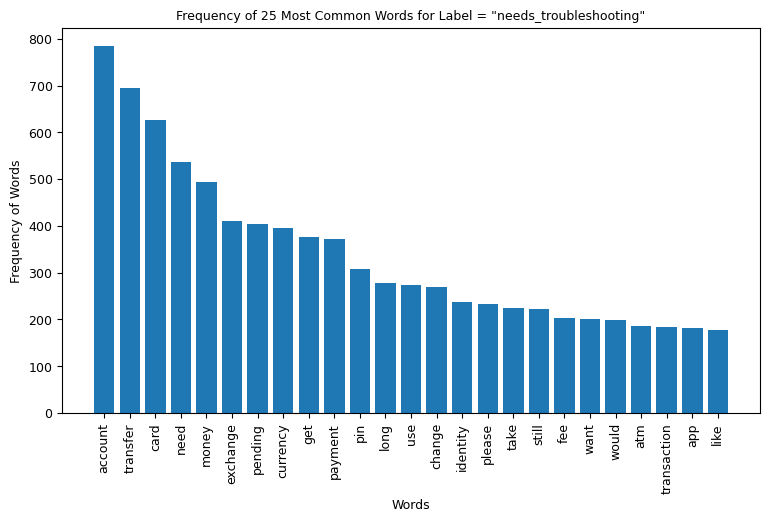

In [53]:
group_by = df.groupby('label')['text'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_tag = group_by.iloc[2]
words0 = list(zip(*group_by_tag))[0]
freq0 = list(zip(*group_by_tag))[1]
plt.figure(figsize=(9,5))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=9)
plt.ylabel('Frequency of Words', fontsize=9)
plt.yticks(fontsize=9)
plt.xticks(rotation=90, fontsize=9)
plt.title(f'Frequency of 25 Most Common Words for Label = "{unique_labels[2]}"', fontsize=9)
plt.show()

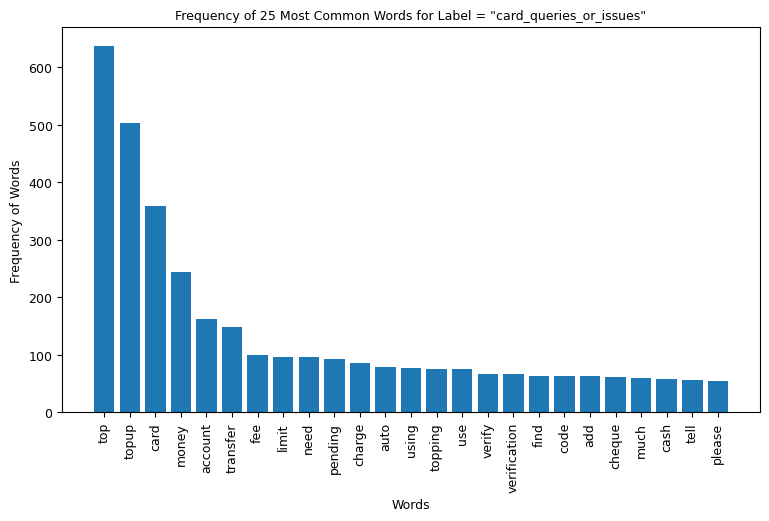

In [54]:
group_by = df.groupby('label')['text'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_tag = group_by.iloc[3]
words0 = list(zip(*group_by_tag))[0]
freq0 = list(zip(*group_by_tag))[1]
plt.figure(figsize=(9,5))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=9)
plt.ylabel('Frequency of Words', fontsize=9)
plt.yticks(fontsize=9)
plt.xticks(rotation=90, fontsize=9)
plt.title(f'Frequency of 25 Most Common Words for Label = "{unique_labels[3]}"', fontsize=9)
plt.show()

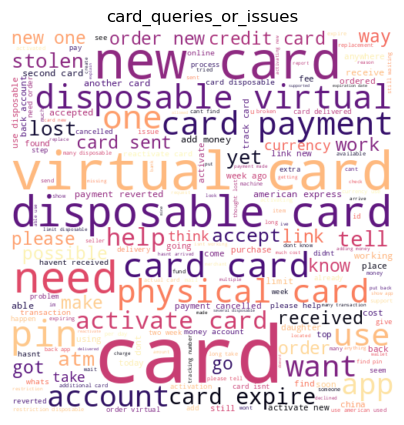

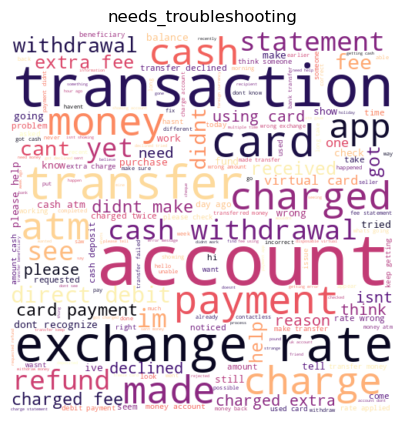

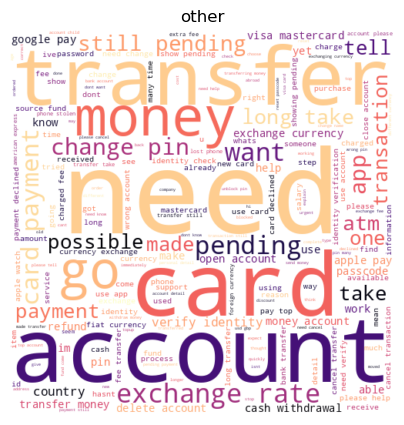

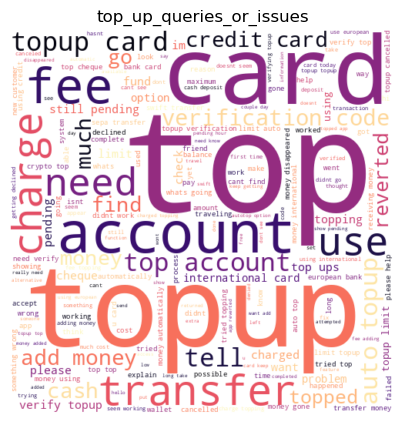

In [55]:
# group the DataFrame by label
grouped = df.groupby('label')

# iterate through each group and generate a wordcloud
for label, group in grouped:
    text = ' '.join(group['text'])
    wordcloud = WordCloud(width=500, height=500, background_color='white', colormap='magma').generate(text)
    plt.figure(figsize=(5,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(label)
    plt.show()

# Test-Train Split

In [56]:
X = df['text'].copy()
y = df['label'].copy()

# Split the dataset into 80% training data and 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the split datasets
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (10467,)
X_test shape: (2617,)
y_train shape: (10467,)
y_test shape: (2617,)


In [57]:
# def evaluate_classifier(name, classifier, X_train, y_train, X_test, y_test, save_model=False, n_decimals=4):
#     classifier.fit(X_train, y_train)
#     y_pred = classifier.predict(X_test)
#     print('-' * 70)
#     print(f'{name.upper()} CLASSIFIER')
#     print(classification_report(y_test, y_pred))
#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred, average='macro')
#     recall = recall_score(y_test, y_pred, average='macro')
#     print(f"Accuracy: {accuracy:.{n_decimals}f}")
#     print(f"Precision: {precision:.{n_decimals}f}")
#     print(f"Recall: {recall:.{n_decimals}f}")
#     print('-' * 70)
#     print('\n')
    
#     # Create a correlation matrix
#     corr_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
#     fig, ax = plt.subplots(figsize=(5,4))
#     sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='g', ax=ax)
#     ax.set_title(f'{name.upper()} CLASSIFIER CORRELATION MATRIX')
#     ax.set_xlabel('Predicted Labels')
#     ax.set_ylabel('True Labels')
#     plt.show()

#     if save_model:
#         with open(f'{name.lower()}_classifier.pkl', 'wb') as f:
#             pickle.dump(classifier, f)

In [58]:
def evaluate_classifier(name, classifier, X_train, y_train, X_test, y_test, save_model=False, n_decimals=4):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print('-' * 70)
    print(f'{name.upper()} CLASSIFIER')
    # Print confusion matrix
    print('\nCONFUSION MATRIX', end='\n\n')
    corr_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    print(corr_matrix, end='\n\n')
    print('\nCLASSIFICATION REPORT')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f"Accuracy: {accuracy:.{n_decimals}f}")
    print(f"Precision: {precision:.{n_decimals}f}")
    print(f"Recall: {recall:.{n_decimals}f}")
    
    # Create a correlation matrix
    fig, ax = plt.subplots(figsize=(5,4))
    sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='g', ax=ax)
    ax.set_title(f'{name.upper()} CLASSIFIER CORRELATION MATRIX')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    plt.show()

    print('-' * 70)
    print('\n')
    
    if save_model:
        with open(f'{name.lower()}_classifier.pkl', 'wb') as f:
            pickle.dump(classifier, f)


# Training with Undersampling

In [59]:
# Perform undersampling on the training set
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train.to_numpy().reshape(-1, 1), y_train)

In [60]:
X_train_resampled

array([['top debit card'],
       ['pin sent separably'],
       ['speak regarding lost card'],
       ...,
       ['accept check'],
       ['topup verification code visible'],
       ['topup isnt working']], dtype=object)

In [61]:
y_train_resampled

0         card_queries_or_issues
1         card_queries_or_issues
2         card_queries_or_issues
3         card_queries_or_issues
4         card_queries_or_issues
                  ...           
5247    top_up_queries_or_issues
5248    top_up_queries_or_issues
5249    top_up_queries_or_issues
5250    top_up_queries_or_issues
5251    top_up_queries_or_issues
Name: label, Length: 5252, dtype: object

----------------------------------------------------------------------
LOGISTIC REGRESSION CLASSIFIER

CONFUSION MATRIX

[[453  18  20  10]
 [ 33 699  89   2]
 [ 81 110 776   7]
 [  1  10   8 300]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.80      0.90      0.85       501
   needs_troubleshooting       0.84      0.85      0.84       823
                   other       0.87      0.80      0.83       974
top_up_queries_or_issues       0.94      0.94      0.94       319

                accuracy                           0.85      2617
               macro avg       0.86      0.87      0.87      2617
            weighted avg       0.85      0.85      0.85      2617

Accuracy: 0.8514
Precision: 0.8605
Recall: 0.8727


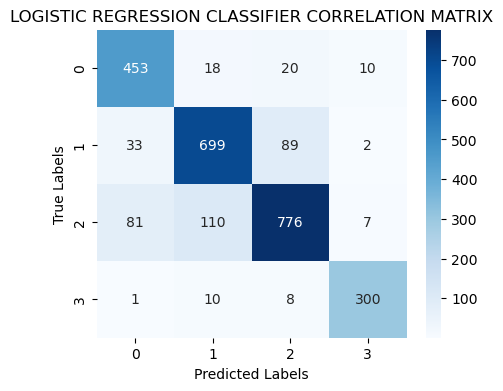

----------------------------------------------------------------------


----------------------------------------------------------------------
NAIVE BAYES CLASSIFIER

CONFUSION MATRIX

[[430  29  24  18]
 [ 28 706  62  27]
 [ 84 142 717  31]
 [  4  14   8 293]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.79      0.86      0.82       501
   needs_troubleshooting       0.79      0.86      0.82       823
                   other       0.88      0.74      0.80       974
top_up_queries_or_issues       0.79      0.92      0.85       319

                accuracy                           0.82      2617
               macro avg       0.81      0.84      0.83      2617
            weighted avg       0.83      0.82      0.82      2617

Accuracy: 0.8200
Precision: 0.8145
Recall: 0.8427


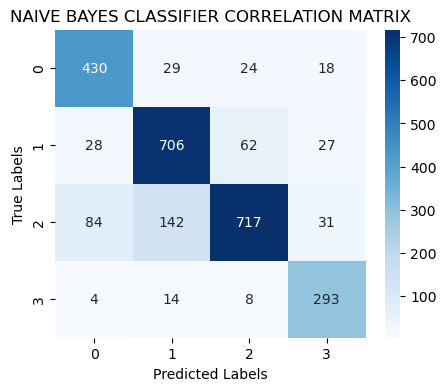

----------------------------------------------------------------------


----------------------------------------------------------------------
SVM CLASSIFIER

CONFUSION MATRIX

[[464   9  21   7]
 [ 39 710  72   2]
 [ 79 104 782   9]
 [  1   9   7 302]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.80      0.93      0.86       501
   needs_troubleshooting       0.85      0.86      0.86       823
                   other       0.89      0.80      0.84       974
top_up_queries_or_issues       0.94      0.95      0.95       319

                accuracy                           0.86      2617
               macro avg       0.87      0.88      0.88      2617
            weighted avg       0.87      0.86      0.86      2617

Accuracy: 0.8628
Precision: 0.8699
Recall: 0.8846


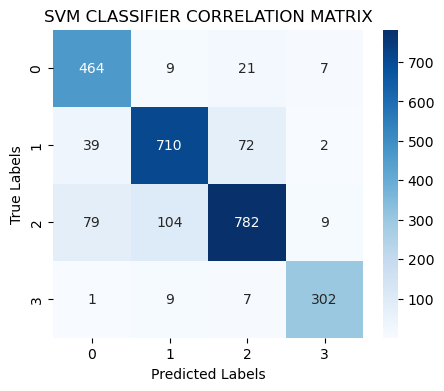

----------------------------------------------------------------------


----------------------------------------------------------------------
ADABOOST CLASSIFIER

CONFUSION MATRIX

[[433  25  34   9]
 [106 413 258  46]
 [173 141 607  53]
 [  5  22  99 193]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.60      0.86      0.71       501
   needs_troubleshooting       0.69      0.50      0.58       823
                   other       0.61      0.62      0.62       974
top_up_queries_or_issues       0.64      0.61      0.62       319

                accuracy                           0.63      2617
               macro avg       0.64      0.65      0.63      2617
            weighted avg       0.64      0.63      0.62      2617

Accuracy: 0.6290
Precision: 0.6351
Recall: 0.6486


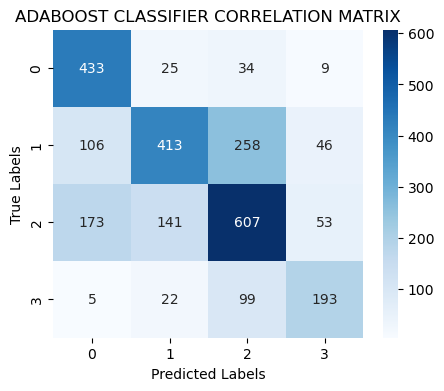

----------------------------------------------------------------------


----------------------------------------------------------------------
RANDOM FOREST CLASSIFIER

CONFUSION MATRIX

[[457  10  23  11]
 [ 34 730  53   6]
 [ 72  51 836  15]
 [  2   7   6 304]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.81      0.91      0.86       501
   needs_troubleshooting       0.91      0.89      0.90       823
                   other       0.91      0.86      0.88       974
top_up_queries_or_issues       0.90      0.95      0.93       319

                accuracy                           0.89      2617
               macro avg       0.88      0.90      0.89      2617
            weighted avg       0.89      0.89      0.89      2617

Accuracy: 0.8892
Precision: 0.8848
Recall: 0.9026


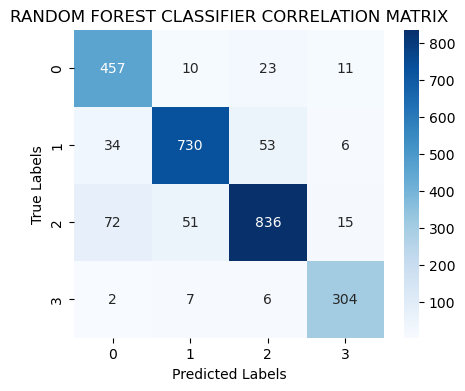

----------------------------------------------------------------------


----------------------------------------------------------------------
GRADIENT BOOSTING CLASSIFIER

CONFUSION MATRIX

[[462   6  21  12]
 [ 74 595 154   0]
 [105  74 784  11]
 [  1   9  13 296]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.72      0.92      0.81       501
   needs_troubleshooting       0.87      0.72      0.79       823
                   other       0.81      0.80      0.81       974
top_up_queries_or_issues       0.93      0.93      0.93       319

                accuracy                           0.82      2617
               macro avg       0.83      0.84      0.83      2617
            weighted avg       0.82      0.82      0.82      2617

Accuracy: 0.8166
Precision: 0.8310
Recall: 0.8445


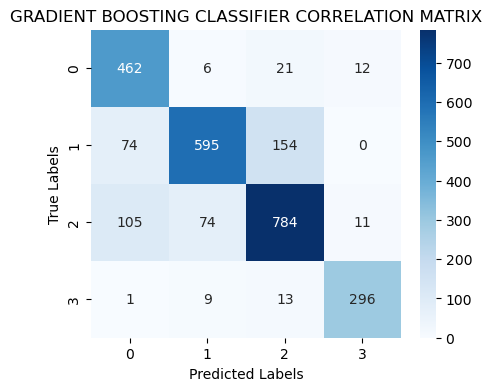

----------------------------------------------------------------------




In [62]:
# Define the classifiers with their corresponding pipelines
classifiers = {
    'logistic regression': Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())]),
    'naive bayes': Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())]),
    'svm': Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC(kernel='linear'))]),
    'adaboost': Pipeline([('tfidf', TfidfVectorizer()), ('clf', AdaBoostClassifier(n_estimators=300))]),  
    'random forest': Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(n_estimators=100, random_state=42))]),
    'gradient boosting': Pipeline([('tfidf', TfidfVectorizer()), ('clf', GradientBoostingClassifier())])
}

# Evaluate each classifier and print evaluation metrics
for name, classifier in classifiers.items():
    evaluate_classifier(name, classifier, X_train_resampled.ravel(), y_train_resampled, X_test, y_test, save_model=True, n_decimals=4)


# Hyperparameter Tuning - Undersampled

Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------------------------------------------------------------------
NAIVE BAYES CLASSIFIER

CONFUSION MATRIX

[[430  29  24  18]
 [ 28 706  62  27]
 [ 84 142 717  31]
 [  4  14   8 293]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.79      0.86      0.82       501
   needs_troubleshooting       0.79      0.86      0.82       823
                   other       0.88      0.74      0.80       974
top_up_queries_or_issues       0.79      0.92      0.85       319

                accuracy                           0.82      2617
               macro avg       0.81      0.84      0.83      2617
            weighted avg       0.83      0.82      0.82      2617

Accuracy: 0.8200
Precision: 0.8145
Recall: 0.8427


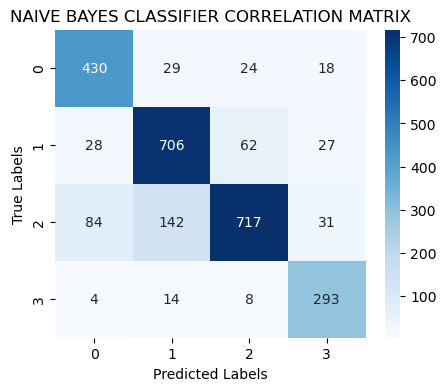

----------------------------------------------------------------------


Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------------------------------------------------------------------
SVM CLASSIFIER

CONFUSION MATRIX

[[455  10  27   9]
 [ 21 743  57   2]
 [ 57  55 854   8]
 [  1   6   8 304]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.85      0.91      0.88       501
   needs_troubleshooting       0.91      0.90      0.91       823
                   other       0.90      0.88      0.89       974
top_up_queries_or_issues       0.94      0.95      0.95       319

                accuracy                           0.90      2617
               macro avg       0.90      0.91      0.91      2617
            weighted avg       0.90      0.90      0.90      2617

Accuracy: 0.9003
Precision: 0.9022
Recall: 0.9102


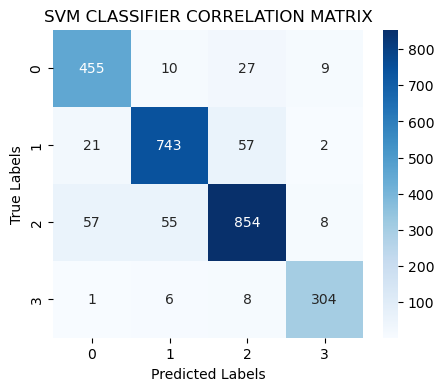

----------------------------------------------------------------------


Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------------------------------------------------------------------
ADABOOST CLASSIFIER

CONFUSION MATRIX

[[433  25  34   9]
 [106 412 259  46]
 [174 141 606  53]
 [  5  22  99 193]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.60      0.86      0.71       501
   needs_troubleshooting       0.69      0.50      0.58       823
                   other       0.61      0.62      0.61       974
top_up_queries_or_issues       0.64      0.61      0.62       319

                accuracy                           0.63      2617
               macro avg       0.63      0.65      0.63      2617
            weighted avg       0.64      0.63      0.62      2617

Accuracy: 0.6282
Precision: 0.6345
Recall: 0.6480


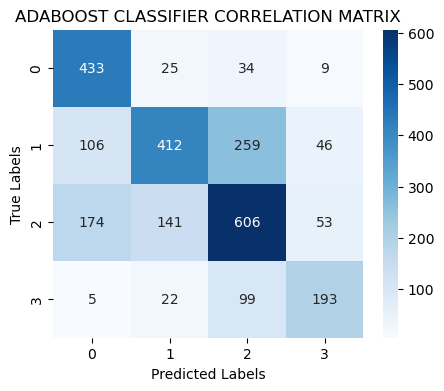

----------------------------------------------------------------------


Fitting 5 folds for each of 81 candidates, totalling 405 fits
----------------------------------------------------------------------
RANDOM FOREST CLASSIFIER

CONFUSION MATRIX

[[441  13  37  10]
 [ 86 630 104   3]
 [107  83 760  24]
 [  7  14  13 285]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.69      0.88      0.77       501
   needs_troubleshooting       0.85      0.77      0.81       823
                   other       0.83      0.78      0.81       974
top_up_queries_or_issues       0.89      0.89      0.89       319

                accuracy                           0.81      2617
               macro avg       0.81      0.83      0.82      2617
            weighted avg       0.82      0.81      0.81      2617

Accuracy: 0.8086
Precision: 0.8140
Recall: 0.8299


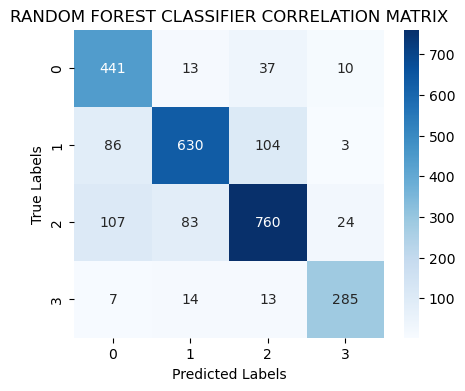

----------------------------------------------------------------------


Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------------------------------------------------------------------
GRADIENT BOOSTING CLASSIFIER

CONFUSION MATRIX

[[464   8  19  10]
 [ 49 686  85   3]
 [ 89  83 791  11]
 [  1   6  10 302]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.77      0.93      0.84       501
   needs_troubleshooting       0.88      0.83      0.85       823
                   other       0.87      0.81      0.84       974
top_up_queries_or_issues       0.93      0.95      0.94       319

                accuracy                           0.86      2617
               macro avg       0.86      0.88      0.87      2617
            weighted avg       0.86      0.86      0.86      2617

Accuracy: 0.8571
Precision: 0.8615
Recall: 0.8796


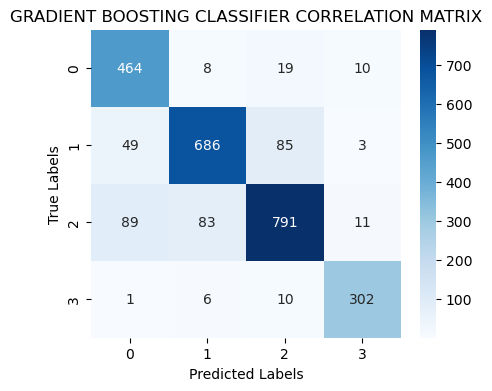

----------------------------------------------------------------------




In [63]:
# Parameters for Logistic Regression
lr_params = {'clf__C': [0.1, 1, 10], 
             'clf__penalty': ['l1', 'l2']}

# Parameters for Multinomial Naive Bayes
nb_params = {'clf__alpha': [0.01, 0.1, 1, 10], 
             'clf__fit_prior': [True, False]}

# Parameters for Support Vector Machine
svm_params = {'clf__C': [0.1, 1, 10], 
              'clf__kernel': ['linear', 'rbf'], 
              'clf__gamma': ['scale', 'auto']}

# Parameters for Random Forest
rf_params = {'clf__n_estimators': [100, 200, 300], 
             'clf__max_depth': [5, 10, 15], 
             'clf__min_samples_split': [2, 5, 10], 
             'clf__min_samples_leaf': [1, 2, 4]}

# Parameters for Gradient Boosting
gb_params = {'clf__n_estimators': [100, 200, 300], 
             'clf__learning_rate': [0.01, 0.1, 1.0], 
             'clf__subsample': [0.5, 0.75, 1.0]}

# Parameters for AdaBoost
ab_params = {'clf__n_estimators': [100, 200, 300], 
             'clf__learning_rate': [0.01, 0.1, 1]}


# Define the classifiers with their corresponding pipelines and hyperparameter grids
classifiers = {
#     'logistic regression': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())]), 'params': lr_params},
    'naive bayes': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())]), 'params': nb_params},
    'svm': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC(kernel='linear'))]), 'params': svm_params},
    'adaboost': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', AdaBoostClassifier())]), 'params': ab_params},
    'random forest': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(random_state=42))]), 'params': rf_params},
    'gradient boosting': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', GradientBoostingClassifier())]), 'params': gb_params},
}

best_params = {}

# Evaluate each classifier and print evaluation metrics
for name, classifier in classifiers.items():
    grid_search = GridSearchCV(classifier['pipeline'], classifier['params'], cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train_resampled.ravel(), y_train_resampled)
    best_params[name] = grid_search.best_params_
    clf = classifier['pipeline'].set_params(**grid_search.best_params_)
    evaluate_classifier(name, clf, X_train_resampled.ravel(), y_train_resampled, X_test, y_test, save_model=True, n_decimals=4)

# Save the best parameters for all models
with open('best_params_undersampled.pkl', 'wb') as f:
    pickle.dump(best_params, f)


## Run with best params from the saved file  - Undersampled 

RUN WITH BEST PARAMETERS

----------------------------------------------------------------------
NAIVE BAYES CLASSIFIER

CONFUSION MATRIX

[[430  29  24  18]
 [ 28 706  62  27]
 [ 84 142 717  31]
 [  4  14   8 293]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.79      0.86      0.82       501
   needs_troubleshooting       0.79      0.86      0.82       823
                   other       0.88      0.74      0.80       974
top_up_queries_or_issues       0.79      0.92      0.85       319

                accuracy                           0.82      2617
               macro avg       0.81      0.84      0.83      2617
            weighted avg       0.83      0.82      0.82      2617

Accuracy: 0.8200
Precision: 0.8145
Recall: 0.8427


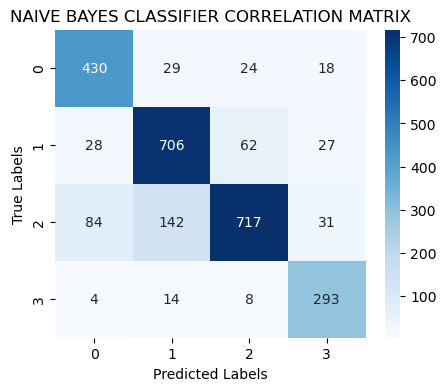

----------------------------------------------------------------------


----------------------------------------------------------------------
SVM CLASSIFIER

CONFUSION MATRIX

[[455  10  27   9]
 [ 21 743  57   2]
 [ 57  55 854   8]
 [  1   6   8 304]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.85      0.91      0.88       501
   needs_troubleshooting       0.91      0.90      0.91       823
                   other       0.90      0.88      0.89       974
top_up_queries_or_issues       0.94      0.95      0.95       319

                accuracy                           0.90      2617
               macro avg       0.90      0.91      0.91      2617
            weighted avg       0.90      0.90      0.90      2617

Accuracy: 0.9003
Precision: 0.9022
Recall: 0.9102


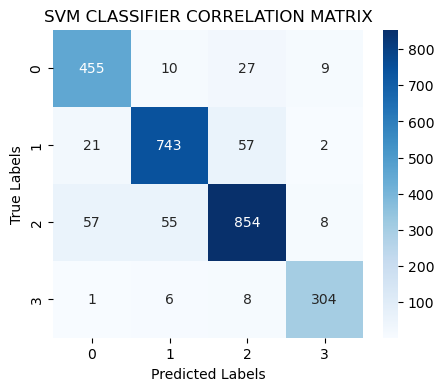

----------------------------------------------------------------------


----------------------------------------------------------------------
ADABOOST CLASSIFIER

CONFUSION MATRIX

[[433  25  34   9]
 [106 413 258  46]
 [174 141 606  53]
 [  5  22  99 193]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.60      0.86      0.71       501
   needs_troubleshooting       0.69      0.50      0.58       823
                   other       0.61      0.62      0.61       974
top_up_queries_or_issues       0.64      0.61      0.62       319

                accuracy                           0.63      2617
               macro avg       0.63      0.65      0.63      2617
            weighted avg       0.64      0.63      0.62      2617

Accuracy: 0.6286
Precision: 0.6348
Recall: 0.6483


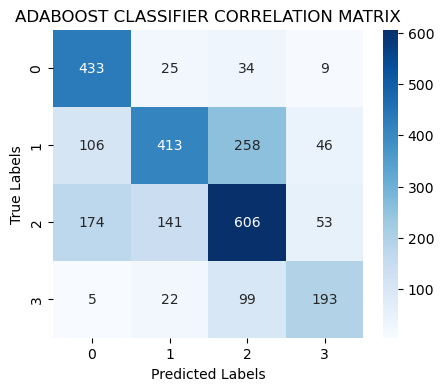

----------------------------------------------------------------------


----------------------------------------------------------------------
RANDOM FOREST CLASSIFIER

CONFUSION MATRIX

[[441  13  37  10]
 [ 86 630 104   3]
 [107  83 760  24]
 [  7  14  13 285]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.69      0.88      0.77       501
   needs_troubleshooting       0.85      0.77      0.81       823
                   other       0.83      0.78      0.81       974
top_up_queries_or_issues       0.89      0.89      0.89       319

                accuracy                           0.81      2617
               macro avg       0.81      0.83      0.82      2617
            weighted avg       0.82      0.81      0.81      2617

Accuracy: 0.8086
Precision: 0.8140
Recall: 0.8299


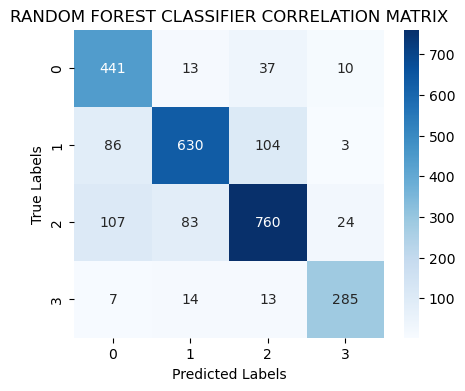

----------------------------------------------------------------------


----------------------------------------------------------------------
GRADIENT BOOSTING CLASSIFIER

CONFUSION MATRIX

[[463   7  22   9]
 [ 50 690  81   2]
 [ 85  73 805  11]
 [  1   6  11 301]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.77      0.92      0.84       501
   needs_troubleshooting       0.89      0.84      0.86       823
                   other       0.88      0.83      0.85       974
top_up_queries_or_issues       0.93      0.94      0.94       319

                accuracy                           0.86      2617
               macro avg       0.87      0.88      0.87      2617
            weighted avg       0.87      0.86      0.86      2617

Accuracy: 0.8632
Precision: 0.8675
Recall: 0.8832


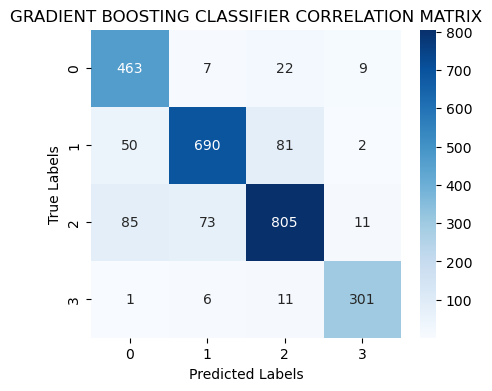

----------------------------------------------------------------------




In [64]:
# Load the best hyperparameters from the saved pickle file
with open('best_params_undersampled.pkl', 'rb') as f:
    best_params = pickle.load(f)

# Define the classifiers with their corresponding pipelines and the best hyperparameters
classifiers = {
#     'logistic regression': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression(**best_params['logistic regression']))])},
    'naive bayes': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB(**{k.replace('clf__', ''): v for k, v in best_params['naive bayes'].items()}))])},
    'svm': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC(**{k.replace('clf__', ''): v for k, v in best_params['svm'].items()}))])},
    'adaboost': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', AdaBoostClassifier(**{k.replace('clf__', ''): v for k, v in best_params['adaboost'].items()}))])},
    'random forest': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(random_state=42, **{k.replace('clf__', ''): v for k, v in best_params['random forest'].items()}))])},
    'gradient boosting': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', GradientBoostingClassifier(**{k.replace('clf__', ''): v for k, v in best_params['gradient boosting'].items()}))])},
}

print('RUN WITH BEST PARAMETERS', end='\n\n')

# Train and evaluate each classifier with the best hyperparameters
for name, classifier in classifiers.items():
    clf = classifier['pipeline']
    clf.fit(X_train_resampled.ravel(), y_train_resampled)
    evaluate_classifier(name, clf, X_train_resampled.ravel(), y_train_resampled, X_test, y_test, save_model=True, n_decimals=4)


# Training with Oversampling

In [65]:
# Perform oversampling on the training set
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.to_numpy().reshape(-1, 1), y_train)

In [66]:
X_train_resampled

array([['way automatic top'],
       ['money asked asked got'],
       ['virtual card going'],
       ...,
       ['top verification code found'],
       ['money added automatically necessary'],
       ['could explain topup gone yet']], dtype=object)

In [67]:
y_train_resampled

0        top_up_queries_or_issues
1           needs_troubleshooting
2           needs_troubleshooting
3                           other
4                           other
                   ...           
15315    top_up_queries_or_issues
15316    top_up_queries_or_issues
15317    top_up_queries_or_issues
15318    top_up_queries_or_issues
15319    top_up_queries_or_issues
Name: label, Length: 15320, dtype: object

----------------------------------------------------------------------
LOGISTIC REGRESSION CLASSIFIER

CONFUSION MATRIX

[[453  17  25   6]
 [ 35 717  70   1]
 [ 60  94 815   5]
 [  1   6  11 301]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.83      0.90      0.86       501
   needs_troubleshooting       0.86      0.87      0.87       823
                   other       0.88      0.84      0.86       974
top_up_queries_or_issues       0.96      0.94      0.95       319

                accuracy                           0.87      2617
               macro avg       0.88      0.89      0.89      2617
            weighted avg       0.87      0.87      0.87      2617

Accuracy: 0.8735
Precision: 0.8829
Recall: 0.8889


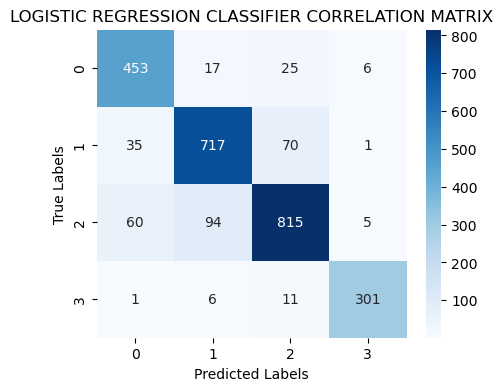

----------------------------------------------------------------------


----------------------------------------------------------------------
NAIVE BAYES CLASSIFIER

CONFUSION MATRIX

[[423  33  30  15]
 [ 20 714  63  26]
 [ 70 135 742  27]
 [  3   8  10 298]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.82      0.84      0.83       501
   needs_troubleshooting       0.80      0.87      0.83       823
                   other       0.88      0.76      0.82       974
top_up_queries_or_issues       0.81      0.93      0.87       319

                accuracy                           0.83      2617
               macro avg       0.83      0.85      0.84      2617
            weighted avg       0.84      0.83      0.83      2617

Accuracy: 0.8319
Precision: 0.8286
Recall: 0.8520


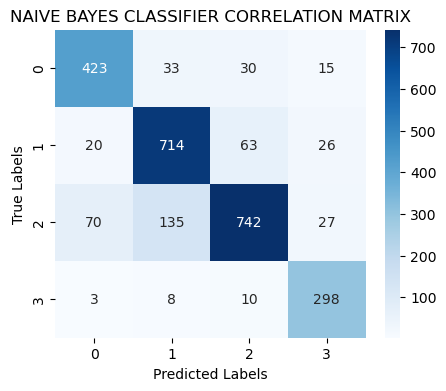

----------------------------------------------------------------------


----------------------------------------------------------------------
SVM CLASSIFIER

CONFUSION MATRIX

[[458  10  27   6]
 [ 37 725  59   2]
 [ 60  92 813   9]
 [  1  11   6 301]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.82      0.91      0.87       501
   needs_troubleshooting       0.87      0.88      0.87       823
                   other       0.90      0.83      0.87       974
top_up_queries_or_issues       0.95      0.94      0.95       319

                accuracy                           0.88      2617
               macro avg       0.88      0.89      0.89      2617
            weighted avg       0.88      0.88      0.88      2617

Accuracy: 0.8777
Precision: 0.8834
Recall: 0.8933


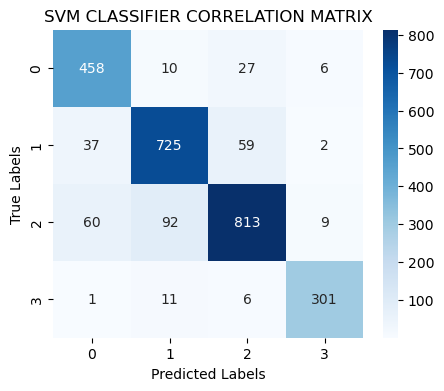

----------------------------------------------------------------------


----------------------------------------------------------------------
ADABOOST CLASSIFIER

CONFUSION MATRIX

[[429  22  48   2]
 [100 325 371  27]
 [203  87 653  31]
 [ 94  11  89 125]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.52      0.86      0.65       501
   needs_troubleshooting       0.73      0.39      0.51       823
                   other       0.56      0.67      0.61       974
top_up_queries_or_issues       0.68      0.39      0.50       319

                accuracy                           0.59      2617
               macro avg       0.62      0.58      0.57      2617
            weighted avg       0.62      0.59      0.57      2617

Accuracy: 0.5854
Precision: 0.6220
Recall: 0.5784


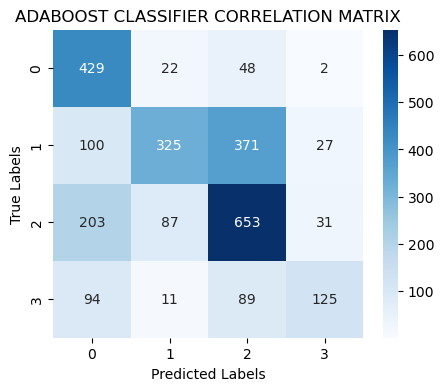

----------------------------------------------------------------------


----------------------------------------------------------------------
RANDOM FOREST CLASSIFIER

CONFUSION MATRIX

[[457  11  26   7]
 [ 20 752  50   1]
 [ 50  34 885   5]
 [  2   8  11 298]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.86      0.91      0.89       501
   needs_troubleshooting       0.93      0.91      0.92       823
                   other       0.91      0.91      0.91       974
top_up_queries_or_issues       0.96      0.93      0.95       319

                accuracy                           0.91      2617
               macro avg       0.92      0.92      0.92      2617
            weighted avg       0.91      0.91      0.91      2617

Accuracy: 0.9140
Precision: 0.9167
Recall: 0.9172


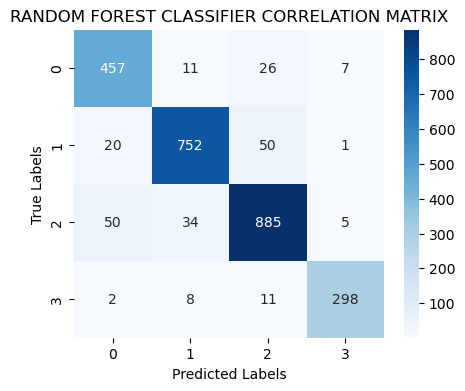

----------------------------------------------------------------------


----------------------------------------------------------------------
GRADIENT BOOSTING CLASSIFIER

CONFUSION MATRIX

[[461   6  23  11]
 [ 69 633 119   2]
 [ 87  85 792  10]
 [  2  10  12 295]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.74      0.92      0.82       501
   needs_troubleshooting       0.86      0.77      0.81       823
                   other       0.84      0.81      0.82       974
top_up_queries_or_issues       0.93      0.92      0.93       319

                accuracy                           0.83      2617
               macro avg       0.84      0.86      0.85      2617
            weighted avg       0.84      0.83      0.83      2617

Accuracy: 0.8334
Precision: 0.8430
Recall: 0.8568


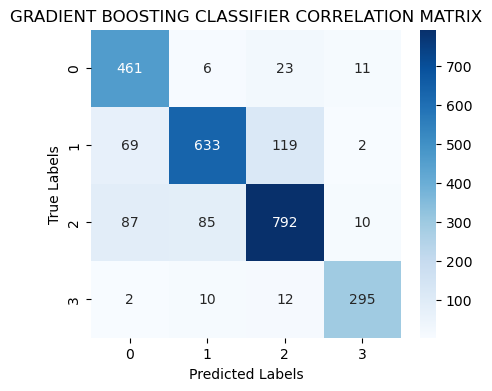

----------------------------------------------------------------------




In [68]:
# Define the classifiers with their corresponding pipelines
classifiers = {
    'logistic regression': Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())]),
    'naive bayes': Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())]),
    'svm': Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC(kernel='linear'))]),
    'adaboost': Pipeline([('tfidf', TfidfVectorizer()), ('clf', AdaBoostClassifier(n_estimators=300))]),  
    'random forest': Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(n_estimators=100, random_state=42))]),
    'gradient boosting': Pipeline([('tfidf', TfidfVectorizer()), ('clf', GradientBoostingClassifier())])
}

# Evaluate each classifier and print evaluation metrics
for name, classifier in classifiers.items():
    evaluate_classifier(name, classifier, X_train_resampled.ravel(), y_train_resampled, X_test, y_test, save_model=True, n_decimals=4)


# Hyperparameter Tuning - Oversampled

Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------------------------------------------------------------------
NAIVE BAYES CLASSIFIER

CONFUSION MATRIX

[[417  34  36  14]
 [ 21 706  71  25]
 [ 61 130 757  26]
 [  5   7  18 289]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.83      0.83      0.83       501
   needs_troubleshooting       0.81      0.86      0.83       823
                   other       0.86      0.78      0.82       974
top_up_queries_or_issues       0.82      0.91      0.86       319

                accuracy                           0.83      2617
               macro avg       0.83      0.84      0.83      2617
            weighted avg       0.83      0.83      0.83      2617

Accuracy: 0.8288
Precision: 0.8268
Recall: 0.8433


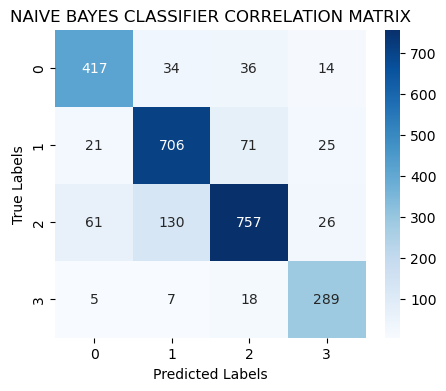

----------------------------------------------------------------------


Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------------------------------------------------------------------
SVM CLASSIFIER

CONFUSION MATRIX

[[459   6  28   8]
 [ 20 753  48   2]
 [ 32  29 910   3]
 [  1   8   7 303]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.90      0.92      0.91       501
   needs_troubleshooting       0.95      0.91      0.93       823
                   other       0.92      0.93      0.93       974
top_up_queries_or_issues       0.96      0.95      0.95       319

                accuracy                           0.93      2617
               macro avg       0.93      0.93      0.93      2617
            weighted avg       0.93      0.93      0.93      2617

Accuracy: 0.9266
Precision: 0.9294
Recall: 0.9288


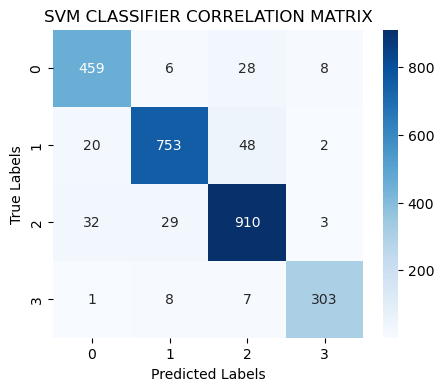

----------------------------------------------------------------------


Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------------------------------------------------------------------
ADABOOST CLASSIFIER

CONFUSION MATRIX

[[429  22  48   2]
 [100 325 371  27]
 [203  87 653  31]
 [ 94  11  89 125]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.52      0.86      0.65       501
   needs_troubleshooting       0.73      0.39      0.51       823
                   other       0.56      0.67      0.61       974
top_up_queries_or_issues       0.68      0.39      0.50       319

                accuracy                           0.59      2617
               macro avg       0.62      0.58      0.57      2617
            weighted avg       0.62      0.59      0.57      2617

Accuracy: 0.5854
Precision: 0.6220
Recall: 0.5784


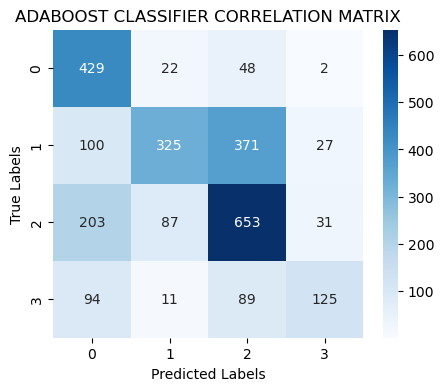

----------------------------------------------------------------------


Fitting 5 folds for each of 81 candidates, totalling 405 fits
----------------------------------------------------------------------
RANDOM FOREST CLASSIFIER

CONFUSION MATRIX

[[441  14  36  10]
 [ 70 661  90   2]
 [103  99 758  14]
 [  4  19  13 283]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.71      0.88      0.79       501
   needs_troubleshooting       0.83      0.80      0.82       823
                   other       0.85      0.78      0.81       974
top_up_queries_or_issues       0.92      0.89      0.90       319

                accuracy                           0.82      2617
               macro avg       0.83      0.84      0.83      2617
            weighted avg       0.82      0.82      0.82      2617

Accuracy: 0.8189
Precision: 0.8270
Recall: 0.8372


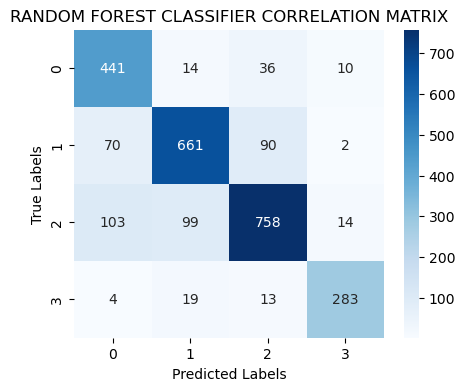

----------------------------------------------------------------------


Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------------------------------------------------------------------
GRADIENT BOOSTING CLASSIFIER

CONFUSION MATRIX

[[443  13  38   7]
 [ 36 707  73   7]
 [ 50  72 846   6]
 [  6   8  12 293]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.83      0.88      0.86       501
   needs_troubleshooting       0.88      0.86      0.87       823
                   other       0.87      0.87      0.87       974
top_up_queries_or_issues       0.94      0.92      0.93       319

                accuracy                           0.87      2617
               macro avg       0.88      0.88      0.88      2617
            weighted avg       0.88      0.87      0.87      2617

Accuracy: 0.8747
Precision: 0.8802
Recall: 0.8826


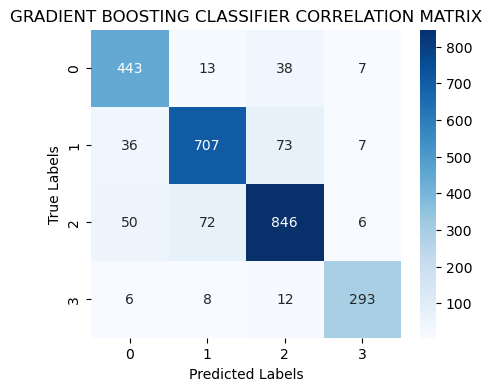

----------------------------------------------------------------------




In [69]:
# Parameters for Logistic Regression
lr_params = {'clf__C': [0.1, 1, 10], 
             'clf__penalty': ['l1', 'l2']}

# Parameters for Multinomial Naive Bayes
nb_params = {'clf__alpha': [0.01, 0.1, 1, 10], 
             'clf__fit_prior': [True, False]}

# Parameters for Support Vector Machine
svm_params = {'clf__C': [0.1, 1, 10], 
              'clf__kernel': ['linear', 'rbf'], 
              'clf__gamma': ['scale', 'auto']}

# Parameters for Random Forest
rf_params = {'clf__n_estimators': [100, 200, 300], 
             'clf__max_depth': [5, 10, 15], 
             'clf__min_samples_split': [2, 5, 10], 
             'clf__min_samples_leaf': [1, 2, 4]}

# Parameters for Gradient Boosting
gb_params = {'clf__n_estimators': [100, 200, 300], 
             'clf__learning_rate': [0.01, 0.1, 1.0], 
             'clf__subsample': [0.5, 0.75, 1.0]}

# Parameters for AdaBoost
ab_params = {'clf__n_estimators': [100, 200, 300], 
             'clf__learning_rate': [0.01, 0.1, 1]}


# Define the classifiers with their corresponding pipelines and hyperparameter grids
classifiers = {
#     'logistic regression': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())]), 'params': lr_params},
    'naive bayes': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())]), 'params': nb_params},
    'svm': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC(kernel='linear'))]), 'params': svm_params},
    'adaboost': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', AdaBoostClassifier())]), 'params': ab_params},
    'random forest': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(random_state=42))]), 'params': rf_params},
    'gradient boosting': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', GradientBoostingClassifier())]), 'params': gb_params},
}

best_params = {}

# Evaluate each classifier and print evaluation metrics
for name, classifier in classifiers.items():
    grid_search = GridSearchCV(classifier['pipeline'], classifier['params'], cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train_resampled.ravel(), y_train_resampled)
    best_params[name] = grid_search.best_params_
    clf = classifier['pipeline'].set_params(**grid_search.best_params_)
    evaluate_classifier(name, clf, X_train_resampled.ravel(), y_train_resampled, X_test, y_test, save_model=True, n_decimals=4)

# Save the best parameters for all models
with open('best_params_oversampled.pkl', 'wb') as f:
    pickle.dump(best_params, f)


## Run with best params from the saved file  - Oversampled 

RUN WITH BEST PARAMETERS

----------------------------------------------------------------------
NAIVE BAYES CLASSIFIER

CONFUSION MATRIX

[[417  34  36  14]
 [ 21 706  71  25]
 [ 61 130 757  26]
 [  5   7  18 289]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.83      0.83      0.83       501
   needs_troubleshooting       0.81      0.86      0.83       823
                   other       0.86      0.78      0.82       974
top_up_queries_or_issues       0.82      0.91      0.86       319

                accuracy                           0.83      2617
               macro avg       0.83      0.84      0.83      2617
            weighted avg       0.83      0.83      0.83      2617

Accuracy: 0.8288
Precision: 0.8268
Recall: 0.8433


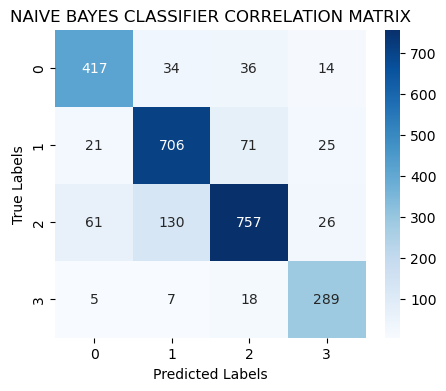

----------------------------------------------------------------------


----------------------------------------------------------------------
SVM CLASSIFIER

CONFUSION MATRIX

[[459   6  28   8]
 [ 20 753  48   2]
 [ 32  29 910   3]
 [  1   8   7 303]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.90      0.92      0.91       501
   needs_troubleshooting       0.95      0.91      0.93       823
                   other       0.92      0.93      0.93       974
top_up_queries_or_issues       0.96      0.95      0.95       319

                accuracy                           0.93      2617
               macro avg       0.93      0.93      0.93      2617
            weighted avg       0.93      0.93      0.93      2617

Accuracy: 0.9266
Precision: 0.9294
Recall: 0.9288


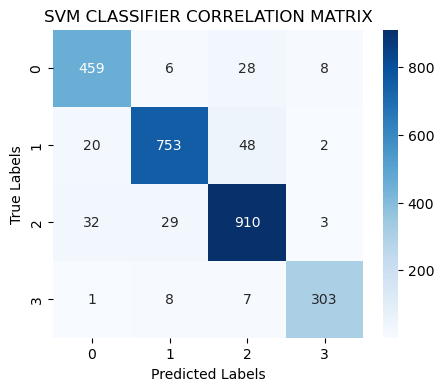

----------------------------------------------------------------------


----------------------------------------------------------------------
ADABOOST CLASSIFIER

CONFUSION MATRIX

[[429  22  48   2]
 [100 325 371  27]
 [203  87 653  31]
 [ 94  11  89 125]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.52      0.86      0.65       501
   needs_troubleshooting       0.73      0.39      0.51       823
                   other       0.56      0.67      0.61       974
top_up_queries_or_issues       0.68      0.39      0.50       319

                accuracy                           0.59      2617
               macro avg       0.62      0.58      0.57      2617
            weighted avg       0.62      0.59      0.57      2617

Accuracy: 0.5854
Precision: 0.6220
Recall: 0.5784


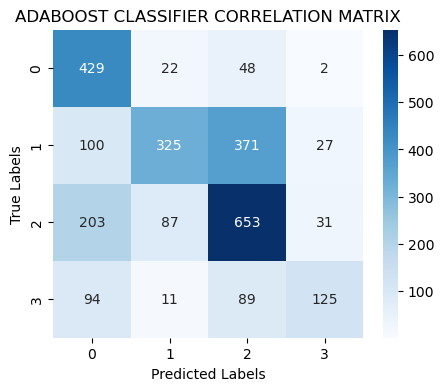

----------------------------------------------------------------------


----------------------------------------------------------------------
RANDOM FOREST CLASSIFIER

CONFUSION MATRIX

[[441  14  36  10]
 [ 70 661  90   2]
 [103  99 758  14]
 [  4  19  13 283]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.71      0.88      0.79       501
   needs_troubleshooting       0.83      0.80      0.82       823
                   other       0.85      0.78      0.81       974
top_up_queries_or_issues       0.92      0.89      0.90       319

                accuracy                           0.82      2617
               macro avg       0.83      0.84      0.83      2617
            weighted avg       0.82      0.82      0.82      2617

Accuracy: 0.8189
Precision: 0.8270
Recall: 0.8372


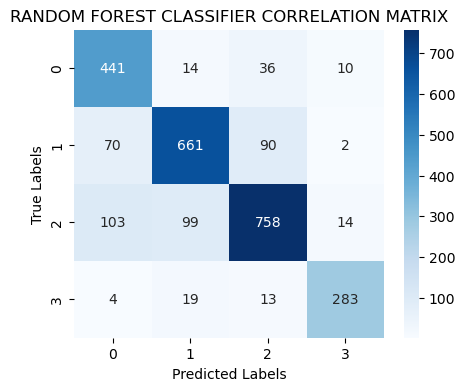

----------------------------------------------------------------------


----------------------------------------------------------------------
GRADIENT BOOSTING CLASSIFIER

CONFUSION MATRIX

[[442  19  32   8]
 [ 38 712  68   5]
 [ 52  74 841   7]
 [  5  11  11 292]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.82      0.88      0.85       501
   needs_troubleshooting       0.87      0.87      0.87       823
                   other       0.88      0.86      0.87       974
top_up_queries_or_issues       0.94      0.92      0.93       319

                accuracy                           0.87      2617
               macro avg       0.88      0.88      0.88      2617
            weighted avg       0.87      0.87      0.87      2617

Accuracy: 0.8739
Precision: 0.8787
Recall: 0.8815


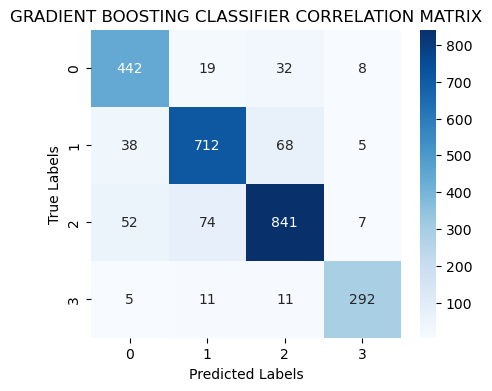

----------------------------------------------------------------------




In [70]:
# Load the best hyperparameters from the saved pickle file
with open('best_params_oversampled.pkl', 'rb') as f:
    best_params = pickle.load(f)

# Define the classifiers with their corresponding pipelines and the best hyperparameters
classifiers = {
#     'logistic regression': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression(**best_params['logistic regression']))])},
    'naive bayes': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB(**{k.replace('clf__', ''): v for k, v in best_params['naive bayes'].items()}))])},
    'svm': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC(**{k.replace('clf__', ''): v for k, v in best_params['svm'].items()}))])},
    'adaboost': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', AdaBoostClassifier(**{k.replace('clf__', ''): v for k, v in best_params['adaboost'].items()}))])},
    'random forest': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(random_state=42, **{k.replace('clf__', ''): v for k, v in best_params['random forest'].items()}))])},
    'gradient boosting': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', GradientBoostingClassifier(**{k.replace('clf__', ''): v for k, v in best_params['gradient boosting'].items()}))])},
}

print('RUN WITH BEST PARAMETERS', end='\n\n')

# Train and evaluate each classifier with the best hyperparameters
for name, classifier in classifiers.items():
    clf = classifier['pipeline']
    clf.fit(X_train_resampled.ravel(), y_train_resampled)
    evaluate_classifier(name, clf, X_train_resampled.ravel(), y_train_resampled, X_test, y_test, save_model=True, n_decimals=4)


In [71]:
best_params

{'naive bayes': {'clf__alpha': 0.1, 'clf__fit_prior': True},
 'svm': {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'},
 'adaboost': {'clf__learning_rate': 1, 'clf__n_estimators': 300},
 'random forest': {'clf__max_depth': 15,
  'clf__min_samples_leaf': 1,
  'clf__min_samples_split': 2,
  'clf__n_estimators': 300},
 'gradient boosting': {'clf__learning_rate': 1.0,
  'clf__n_estimators': 300,
  'clf__subsample': 1.0}}

# IMPORTS

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from keras.layers import SimpleRNN, Dense
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
#import warnings
#warnings.filterwarnings(action='ignore')

2023-03-30 07:02:06.347369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 07:02:06.611229: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-30 07:02:06.621918: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-30 07:02:06.621953: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

# LOADING THE CLEANED AND FILLED DATASET

In [2]:
df = pd.read_csv('final_project_cleaned.csv')

In [3]:
df=df[:1000]

# PREPROCESSING AND PADDING

In [4]:


# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)



  


# DEFINE THE NEURAL NETWORK MODELS WITH DEFAULT PARAMS PASSED 

In [5]:
# Define the models
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return rnn_model

def create_cnn(num_words=20000, embedding_size=128, filter_size=32, kernel_size=3, pool_size=2, dense_size=64, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



def create_bilstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# OVERSAMPLING DATASET AND ENCODING Y LABELS

In [6]:
#oversampling
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)






#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

# RUNNING MODELS ON OVERSAMPLED DATASET AND PERFORMANCE ANALYSIS

2023-03-30 07:02:23.795492: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-30 07:02:23.795545: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-30 07:02:23.795583: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2023-03-30 07:02:23.795967: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training rnn model...
Epoch 1/10
31/31 [==============================] - 4s 69ms/step - loss: 0.5767 - accuracy: 0.3218 - val_loss: 0.7269 - val_accuracy: 0.0776
Epoch 2/10
31/31 [==============================] - 2s 58ms/step - loss: 0.5177 - accuracy: 0.4372 - val_loss: 0.7268 - val_accuracy: 0.1224
Epoch 3/10
31/31 [==============================] - 2s 51ms/step - loss: 0.4168 - accuracy: 0.6619 - val_loss: 0.6467 - val_accuracy: 0.1224
Epoch 4/10
31/31 [==============================] - 2s 52ms/step - loss: 0.2809 - accuracy: 0.7998 - val_loss: 0.4242 - val_accuracy: 0.6857
Epoch 5/10
31/31 [==============================] - 2s 51ms/step - loss: 0.1800 - accuracy: 0.8876 - val_loss: 0.2388 - val_accuracy: 0.8735
Epoch 6/10
31/31 [==============================] - 2s 51ms/step - loss: 0.1138 - accuracy: 0.9448 - val_loss: 0.0985 - val_accuracy: 0.9755
Epoch 7/10
31/31 [==============================] - 2s 51ms/step - loss: 0.0686 - accuracy: 0.9745 - val_loss: 0.0411 - val_accuracy

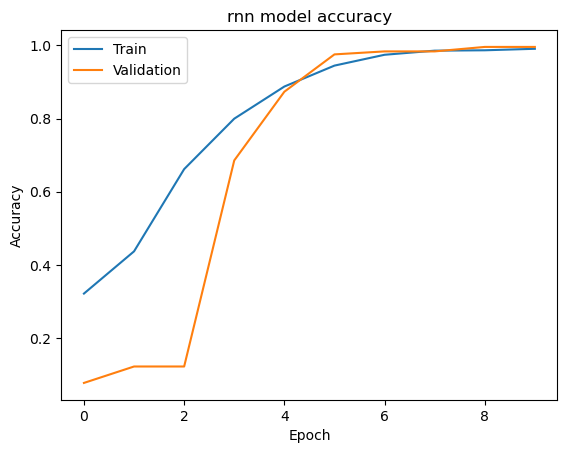

Training cnn model...
Epoch 1/10
31/31 [==============================] - 2s 40ms/step - loss: 0.6223 - accuracy: 0.2880 - val_loss: 0.8200 - val_accuracy: 0.1306
Epoch 2/10
31/31 [==============================] - 1s 30ms/step - loss: 0.5409 - accuracy: 0.3616 - val_loss: 0.7687 - val_accuracy: 0.1061
Epoch 3/10
31/31 [==============================] - 1s 31ms/step - loss: 0.4826 - accuracy: 0.5455 - val_loss: 0.7699 - val_accuracy: 0.1224
Epoch 4/10
31/31 [==============================] - 1s 30ms/step - loss: 0.3680 - accuracy: 0.6946 - val_loss: 0.7606 - val_accuracy: 0.1347
Epoch 5/10
31/31 [==============================] - 1s 31ms/step - loss: 0.2789 - accuracy: 0.7865 - val_loss: 0.6951 - val_accuracy: 0.1347
Epoch 6/10
31/31 [==============================] - 1s 31ms/step - loss: 0.2179 - accuracy: 0.8355 - val_loss: 0.5843 - val_accuracy: 0.1306
Epoch 7/10
31/31 [==============================] - 1s 31ms/step - loss: 0.1781 - accuracy: 0.8560 - val_loss: 0.5413 - val_accuracy

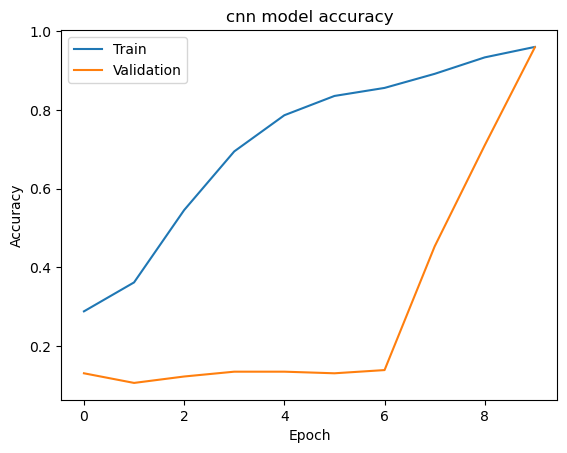

Training lstm model...
Epoch 1/10
31/31 [==============================] - 7s 120ms/step - loss: 0.5977 - accuracy: 0.3075 - val_loss: 0.7365 - val_accuracy: 0.0000e+00
Epoch 2/10
31/31 [==============================] - 3s 91ms/step - loss: 0.5285 - accuracy: 0.3892 - val_loss: 0.7345 - val_accuracy: 0.0000e+00
Epoch 3/10
31/31 [==============================] - 3s 99ms/step - loss: 0.4334 - accuracy: 0.6129 - val_loss: 0.7591 - val_accuracy: 0.1184
Epoch 4/10
31/31 [==============================] - 3s 96ms/step - loss: 0.3268 - accuracy: 0.7324 - val_loss: 0.6514 - val_accuracy: 0.1184
Epoch 5/10
31/31 [==============================] - 3s 94ms/step - loss: 0.2401 - accuracy: 0.8039 - val_loss: 0.5064 - val_accuracy: 0.2286
Epoch 6/10
31/31 [==============================] - 3s 93ms/step - loss: 0.1659 - accuracy: 0.8856 - val_loss: 0.3078 - val_accuracy: 0.7551
Epoch 7/10
31/31 [==============================] - 3s 93ms/step - loss: 0.1199 - accuracy: 0.9356 - val_loss: 0.1355 - va

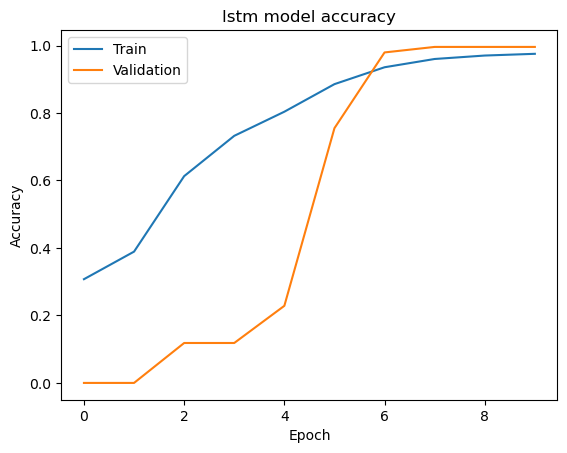

Training bilstm model...
Epoch 1/10
31/31 [==============================] - 10s 167ms/step - loss: 0.5875 - accuracy: 0.3238 - val_loss: 0.7625 - val_accuracy: 0.1388
Epoch 2/10
31/31 [==============================] - 4s 122ms/step - loss: 0.5249 - accuracy: 0.4116 - val_loss: 0.7896 - val_accuracy: 0.0367
Epoch 3/10
31/31 [==============================] - 4s 118ms/step - loss: 0.4186 - accuracy: 0.6568 - val_loss: 0.7499 - val_accuracy: 0.1347
Epoch 4/10
31/31 [==============================] - 4s 120ms/step - loss: 0.3205 - accuracy: 0.7365 - val_loss: 0.7510 - val_accuracy: 0.1265
Epoch 5/10
31/31 [==============================] - 4s 118ms/step - loss: 0.2254 - accuracy: 0.8253 - val_loss: 0.5323 - val_accuracy: 0.4204
Epoch 6/10
31/31 [==============================] - 3s 106ms/step - loss: 0.1479 - accuracy: 0.9009 - val_loss: 0.2128 - val_accuracy: 0.8571
Epoch 7/10
31/31 [==============================] - 3s 105ms/step - loss: 0.1127 - accuracy: 0.9418 - val_loss: 0.1913 - v

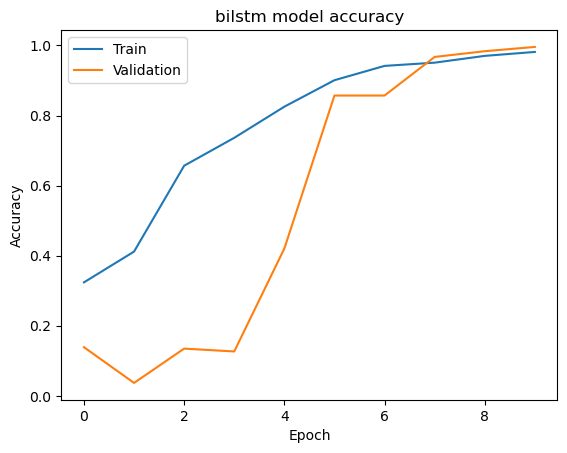

In [7]:
# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}


# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# UNDERSAMPLING DATASET AND ENCODING Y LABELS

In [8]:
#undersampling
ros = RandomUnderSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)






#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

# RUNNING MODELS ON UNDERSAMPLED DATASET AND PERFORMANCE ANALYSIS

Training rnn model...
Epoch 1/10
10/10 [==============================] - 2s 100ms/step - loss: 0.6458 - accuracy: 0.2730 - val_loss: 0.7060 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 1s 54ms/step - loss: 0.5523 - accuracy: 0.3289 - val_loss: 0.9187 - val_accuracy: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 1s 52ms/step - loss: 0.5300 - accuracy: 0.3487 - val_loss: 0.9082 - val_accuracy: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 1s 54ms/step - loss: 0.5205 - accuracy: 0.3849 - val_loss: 0.8634 - val_accuracy: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 1s 55ms/step - loss: 0.5055 - accuracy: 0.5033 - val_loss: 0.8761 - val_accuracy: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 1s 55ms/step - loss: 0.4710 - accuracy: 0.6513 - val_loss: 0.8511 - val_accuracy: 0.0000e+00
Epoch 7/10
10/10 [==============================] - 1s 55ms/step - loss: 0.4293 - accuracy: 0.7697 - val_lo

/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solo

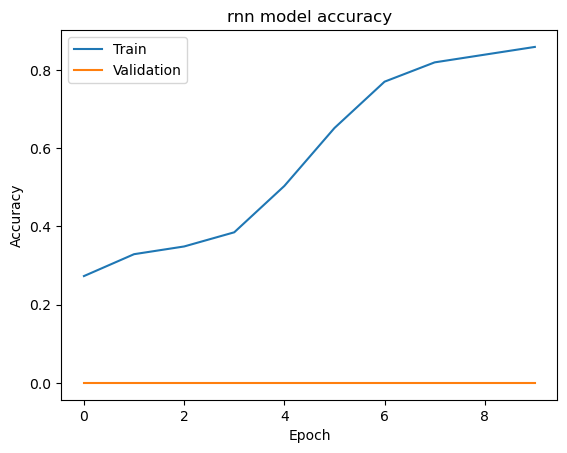

Training cnn model...
Epoch 1/10
10/10 [==============================] - 2s 61ms/step - loss: 0.6744 - accuracy: 0.2895 - val_loss: 0.6522 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 0s 36ms/step - loss: 0.6061 - accuracy: 0.3125 - val_loss: 0.6476 - val_accuracy: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 0s 36ms/step - loss: 0.5550 - accuracy: 0.3224 - val_loss: 0.7710 - val_accuracy: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 0s 35ms/step - loss: 0.5380 - accuracy: 0.3487 - val_loss: 0.8249 - val_accuracy: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 0s 34ms/step - loss: 0.5265 - accuracy: 0.3849 - val_loss: 0.9121 - val_accuracy: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 0s 34ms/step - loss: 0.5083 - accuracy: 0.5000 - val_loss: 0.9218 - val_accuracy: 0.0000e+00
Epoch 7/10
10/10 [==============================] - 0s 35ms/step - loss: 0.4961 - accuracy: 0.4737 - val_los

/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solo

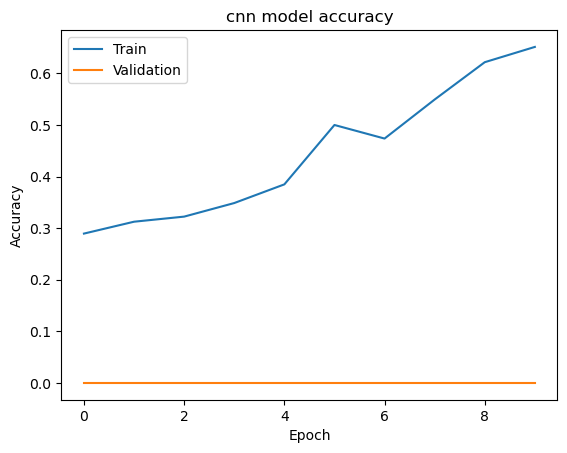

Training lstm model...
Epoch 1/10
10/10 [==============================] - 5s 253ms/step - loss: 0.6752 - accuracy: 0.3191 - val_loss: 0.6946 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 1s 92ms/step - loss: 0.5777 - accuracy: 0.3125 - val_loss: 0.8140 - val_accuracy: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 1s 92ms/step - loss: 0.5407 - accuracy: 0.3388 - val_loss: 0.9539 - val_accuracy: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 1s 92ms/step - loss: 0.5362 - accuracy: 0.3421 - val_loss: 0.9483 - val_accuracy: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 1s 93ms/step - loss: 0.5204 - accuracy: 0.4178 - val_loss: 0.8709 - val_accuracy: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 1s 95ms/step - loss: 0.5148 - accuracy: 0.4276 - val_loss: 0.9171 - val_accuracy: 0.0000e+00
Epoch 7/10
10/10 [==============================] - 1s 99ms/step - loss: 0.4823 - accuracy: 0.5691 - val_l

/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solo

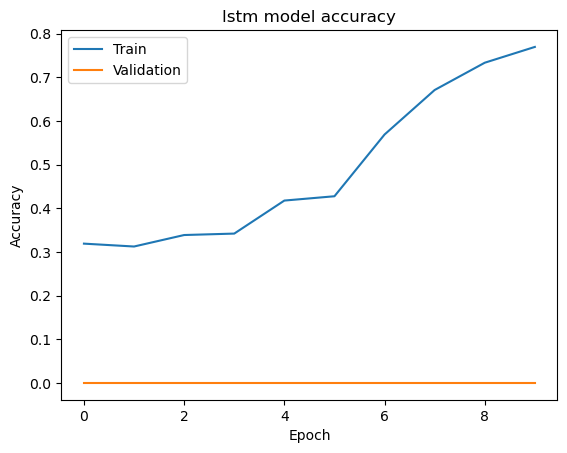

Training bilstm model...
Epoch 1/10
10/10 [==============================] - 7s 231ms/step - loss: 0.6651 - accuracy: 0.3257 - val_loss: 0.6492 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 1s 117ms/step - loss: 0.5749 - accuracy: 0.2895 - val_loss: 0.8566 - val_accuracy: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 1s 114ms/step - loss: 0.5412 - accuracy: 0.3553 - val_loss: 0.8113 - val_accuracy: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 1s 115ms/step - loss: 0.5332 - accuracy: 0.3618 - val_loss: 0.8595 - val_accuracy: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 1s 113ms/step - loss: 0.5000 - accuracy: 0.4803 - val_loss: 0.8044 - val_accuracy: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 1s 114ms/step - loss: 0.4487 - accuracy: 0.6086 - val_loss: 0.9527 - val_accuracy: 0.0000e+00
Epoch 7/10
10/10 [==============================] - 1s 109ms/step - loss: 0.4033 - accuracy: 0.6513

/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solo

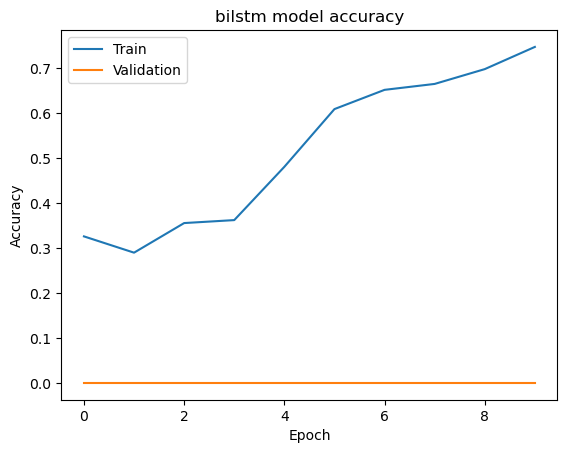

In [9]:
# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}


# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# FINDING BEST PARAMS FOR OVERSAMPLED DATA

In [10]:
#oversampling
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)






#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

# RNN

In [11]:
# Define the parameter grid to search over
param_grid = {
    'num_words': [20000, 50000],
    'embedding_dim': [50, 100],
    'rnn_units': [32, 64],
    'dense_size': [32, 64],
    'dropout_rate': [0.2,0.3],
    'max_seq_length': [100],
}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

rnn_oversampled_best_params = grid_result.best_params_

/tmp/ipykernel_11379/1531335905.py:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
13/13 [==============================] - 0s 12ms/step - loss: 0.5774 - accuracy: 0.1324


26/26 [==============================] - 3s 67ms/step - loss: 0.5973 - accuracy: 0.3431


39/39 [==============================] - 3s 48ms/step - loss: 0.6103 - accuracy: 0.2704
Best parameters: {'dense_size': 32, 'dropout_rate': 0.2, 'embedding_dim': 50, 'max_seq_length': 100, 'num_words': 50000, 'rnn_units': 32}
Best accuracy: 0.29411765933036804


In [12]:
rnn_oversampled_best_params

{'dense_size': 32,
 'dropout_rate': 0.2,
 'embedding_dim': 50,
 'max_seq_length': 100,
 'num_words': 50000,
 'rnn_units': 32}

# CNN

In [13]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000, 50000],
              'embedding_size': [64, 128],
              'filter_size': [32, 64],
              'kernel_size': [3, 5],
              'pool_size': [2, 3],
              'dense_size': [64, 128],
              'dropout_rate': [0.2, 0.3]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_cnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

cnn_oversampled_best_params = grid_result.best_params_

Fitting 3 folds for each of 128 candidates, totalling 384 fits
Epoch 1/5


/tmp/ipykernel_56883/3953337257.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, epochs=epochs, batch_size=batch_size)


100/100 [==============================] - 3s 24ms/step - loss: 0.5755 - accuracy: 0.3350
Epoch 2/5
100/100 [==============================] - 2s 25ms/step - loss: 0.3320 - accuracy: 0.7220
Epoch 3/5
100/100 [==============================] - 2s 25ms/step - loss: 0.1852 - accuracy: 0.8582
Epoch 4/5
100/100 [==============================] - 2s 25ms/step - loss: 0.1336 - accuracy: 0.9086
Epoch 5/5
50/50 [==============================] - 0s 2ms/step - loss: 0.2349 - accuracy: 0.8229
Epoch 1/5
 86/100 [========================>.....] - ETA: 0s - loss: 0.5814 - accuracy: 0.3779

KeyboardInterrupt: 

In [ ]:
cnn_oversampled_best_params

# LSTM

In [14]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000,50000],
              'lstm_size': [64,128],
              'embedding_size':[64,128],
              'dropout_rate': [0.2,0.3],
              'dense_size': [64,128]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_lstm, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

lstm_oversampled_best_params = grid_result.best_params_

/tmp/ipykernel_56883/3755137833.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_lstm, epochs=epochs, batch_size=batch_size)
2023-03-30 02:02:22.527440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:02:22.528493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/5


2023-03-30 02:02:22.734416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:02:22.735546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 02:02:22.736619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

100/100 [==============================] - 6s 46ms/step - loss: 0.5340 - accuracy: 0.4286
Epoch 2/5
 28/100 [=======>......................] - ETA: 3s - loss: 0.2951 - accuracy: 0.7478

KeyboardInterrupt: 

In [ ]:
lstm_oversampled_best_params

# BILSTM

In [15]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000,50000],
              'lstm_size': [64,128],
              'embedding_size':[64,128],
              'dropout_rate': [0.2,0.3],
              'dense_size': [64,128]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_bilstm, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

bilstm_oversampled_best_params = grid_result.best_params_

/tmp/ipykernel_56883/1400334571.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_bilstm, epochs=epochs, batch_size=batch_size)
2023-03-30 02:02:33.234542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:02:33.235626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/conc

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/5


2023-03-30 02:02:33.634064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-30 02:02:33.669091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:02:33.670470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

100/100 [==============================] - 8s 55ms/step - loss: 0.5448 - accuracy: 0.3961
Epoch 2/5
 45/100 [============>.................] - ETA: 2s - loss: 0.2959 - accuracy: 0.7486

KeyboardInterrupt: 

In [ ]:
bilstm_oversampled_best_params

# FINDING BEST PARAMS FOR UNDERSAMPLED DATA

In [16]:
#undersampling
ros = RandomUnderSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)






#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

# RNN

In [17]:
# Define the parameter grid to search over
param_grid = {
    'num_words': [20000, 50000],
    'embedding_dim': [50, 100],
    'rnn_units': [32, 64],
    'dense_size': [32, 64],
    'dropout_rate': [0.2,0.3],
    'max_seq_length': [100],
}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

rnn_undersampled_best_params = grid_result.best_params_

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/5


/tmp/ipykernel_56883/1669981765.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)


32/32 [==============================] - 2s 26ms/step - loss: 0.6074 - accuracy: 0.3680
Epoch 2/5
32/32 [==============================] - 1s 27ms/step - loss: 0.5117 - accuracy: 0.3940
Epoch 3/5
32/32 [==============================] - 1s 28ms/step - loss: 0.4837 - accuracy: 0.4590
Epoch 4/5
32/32 [==============================] - 1s 26ms/step - loss: 0.4385 - accuracy: 0.6290
Epoch 5/5
16/16 [==============================] - 0s 4ms/step - loss: 0.9784 - accuracy: 0.1480
Epoch 1/5
32/32 [==============================] - 2s 27ms/step - loss: 0.5978 - accuracy: 0.3420
Epoch 2/5
32/32 [==============================] - 1s 26ms/step - loss: 0.5156 - accuracy: 0.4590
Epoch 3/5
32/32 [==============================] - 1s 26ms/step - loss: 0.4503 - accuracy: 0.6440
Epoch 4/5
32/32 [==============================] - 1s 28ms/step - loss: 0.3608 - accuracy: 0.7150
Epoch 5/5
16/16 [==============================] - 0s 5ms/step - loss: 0.7413 - accuracy: 0.0360
Epoch 1/5
32/32 [===============

KeyboardInterrupt: 

In [ ]:
rnn_undersampled_best_params

# CNN

In [18]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000, 50000],
              'embedding_size': [64, 128],
              'filter_size': [32, 64],
              'kernel_size': [3, 5],
              'pool_size': [2, 3],
              'dense_size': [64, 128],
              'dropout_rate': [0.2, 0.3]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_cnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

cnn_undersampled_best_params = grid_result.best_params_

Fitting 3 folds for each of 128 candidates, totalling 384 fits
Epoch 1/5


/tmp/ipykernel_56883/3953337257.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, epochs=epochs, batch_size=batch_size)


32/32 [==============================] - 1s 24ms/step - loss: 0.5964 - accuracy: 0.3710
Epoch 2/5
32/32 [==============================] - 1s 29ms/step - loss: 0.4849 - accuracy: 0.3800
Epoch 3/5
32/32 [==============================] - 1s 25ms/step - loss: 0.4667 - accuracy: 0.4600
Epoch 4/5
32/32 [==============================] - 1s 25ms/step - loss: 0.3643 - accuracy: 0.6810
Epoch 5/5
16/16 [==============================] - 0s 2ms/step - loss: 1.5430 - accuracy: 0.1440
Epoch 1/5
32/32 [==============================] - 1s 25ms/step - loss: 0.6166 - accuracy: 0.3550
Epoch 2/5
32/32 [==============================] - 1s 26ms/step - loss: 0.5277 - accuracy: 0.3960
Epoch 3/5
32/32 [==============================] - 1s 29ms/step - loss: 0.4999 - accuracy: 0.5270
Epoch 4/5
 1/32 [..............................] - ETA: 1s - loss: 0.4833 - accuracy: 0.5938

KeyboardInterrupt: 

In [ ]:
cnn_undersampled_best_params

# LSTM

In [19]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000,50000],
              'lstm_size': [64,128],
              'embedding_size':[64,128],
              'dropout_rate': [0.2,0.3],
              'dense_size': [64,128]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_lstm, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

lstm_undersampled_best_params = grid_result.best_params_

/tmp/ipykernel_56883/3755137833.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_lstm, epochs=epochs, batch_size=batch_size)
2023-03-30 02:03:23.153656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:03:23.154652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/5


2023-03-30 02:03:23.374432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:03:23.375822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 02:03:23.376940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 3s 44ms/step - loss: 0.5801 - accuracy: 0.3580
Epoch 2/5
32/32 [==============================] - 1s 44ms/step - loss: 0.4797 - accuracy: 0.3770
Epoch 3/5
26/32 [=======================>......] - ETA: 0s - loss: 0.4745 - accuracy: 0.4062

KeyboardInterrupt: 

In [ ]:
lstm_undersampled_best_params

# BILSTM

In [20]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000,50000],
              'lstm_size': [64,128],
              'embedding_size':[64,128],
              'dropout_rate': [0.2,0.3],
              'dense_size': [64,128]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_bilstm, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

bilstm_undersampled_best_params = grid_result.best_params_

/tmp/ipykernel_56883/1400334571.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_bilstm, epochs=epochs, batch_size=batch_size)
2023-03-30 02:03:31.934131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:03:31.935133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/conc

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/5


2023-03-30 02:03:32.044426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-30 02:03:32.078900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:03:32.079896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

32/32 [==============================] - 4s 56ms/step - loss: 0.5523 - accuracy: 0.3580
Epoch 2/5
32/32 [==============================] - 2s 50ms/step - loss: 0.4799 - accuracy: 0.3970
Epoch 3/5
32/32 [==============================] - 2s 54ms/step - loss: 0.4508 - accuracy: 0.4950
Epoch 4/5
 9/32 [=======>......................] - ETA: 1s - loss: 0.3972 - accuracy: 0.6389

KeyboardInterrupt: 

In [ ]:
bilstm_undersampled_best_params

# OVERSAMPLING DATASET AND ENCODING Y LABELS

In [21]:
#oversampling
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)






#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

# DEFINE THE NEURAL NETWORK MODELS WITH BEST PARAMS PASSED (OVERSAMPLED)

In [14]:
def create_rnn(num_words=rnn_oversampled_best_params['num_words'],\
               embedding_dim=rnn_oversampled_best_params['embedding_dim'],\
               rnn_units=rnn_oversampled_best_params['rnn_units'],\
               dense_size=rnn_oversampled_best_params['dense_size'],\
               dropout_rate=rnn_oversampled_best_params['dropout_rate'],\
               max_seq_length=rnn_oversampled_best_params['max_seq_length']):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return rnn_model

def create_cnn(num_words=50000, embedding_size=128, filter_size=32, kernel_size=5, pool_size=3, dense_size=128, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm(num_words=50000, lstm_size=128, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



def create_bilstm(num_words=50000, lstm_size=128, embedding_size=128, dropout_rate=0.2, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# RUNNING MODELS ON OVERSAMPLED DATASET AND PERFORMANCE ANALYSIS

Training rnn model...
Epoch 1/10
31/31 [==============================] - 4s 68ms/step - loss: 0.6079 - accuracy: 0.2707 - val_loss: 0.7137 - val_accuracy: 0.0000e+00
Epoch 2/10
31/31 [==============================] - 2s 50ms/step - loss: 0.5446 - accuracy: 0.3585 - val_loss: 0.7519 - val_accuracy: 0.0000e+00
Epoch 3/10
31/31 [==============================] - 2s 50ms/step - loss: 0.5112 - accuracy: 0.4770 - val_loss: 0.7008 - val_accuracy: 0.0000e+00
Epoch 4/10
31/31 [==============================] - 2s 53ms/step - loss: 0.4377 - accuracy: 0.6027 - val_loss: 0.6906 - val_accuracy: 0.0204
Epoch 5/10
31/31 [==============================] - 2s 54ms/step - loss: 0.3704 - accuracy: 0.6609 - val_loss: 0.6494 - val_accuracy: 0.0694
Epoch 6/10
31/31 [==============================] - 2s 54ms/step - loss: 0.3142 - accuracy: 0.7375 - val_loss: 0.5913 - val_accuracy: 0.1429
Epoch 7/10
31/31 [==============================] - 2s 53ms/step - loss: 0.2451 - accuracy: 0.8386 - val_loss: 0.4482 - 

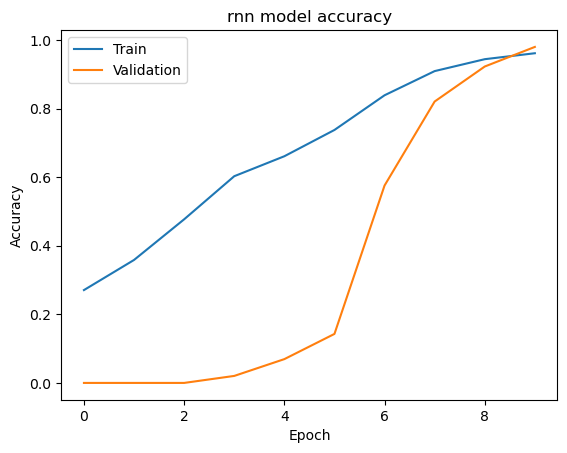

Training cnn model...
Epoch 1/10
31/31 [==============================] - 5s 73ms/step - loss: 0.6063 - accuracy: 0.3207 - val_loss: 0.7842 - val_accuracy: 0.0163
Epoch 2/10
31/31 [==============================] - 2s 60ms/step - loss: 0.5230 - accuracy: 0.4311 - val_loss: 0.7540 - val_accuracy: 0.0735
Epoch 3/10
31/31 [==============================] - 2s 62ms/step - loss: 0.4178 - accuracy: 0.6609 - val_loss: 0.7637 - val_accuracy: 0.1306
Epoch 4/10
31/31 [==============================] - 2s 61ms/step - loss: 0.3130 - accuracy: 0.7446 - val_loss: 0.7345 - val_accuracy: 0.1102
Epoch 5/10
31/31 [==============================] - 2s 60ms/step - loss: 0.2360 - accuracy: 0.8192 - val_loss: 0.6743 - val_accuracy: 0.1306
Epoch 6/10
31/31 [==============================] - 2s 60ms/step - loss: 0.1929 - accuracy: 0.8427 - val_loss: 0.6197 - val_accuracy: 0.1306
Epoch 7/10
31/31 [==============================] - 2s 60ms/step - loss: 0.1544 - accuracy: 0.8682 - val_loss: 0.5931 - val_accuracy

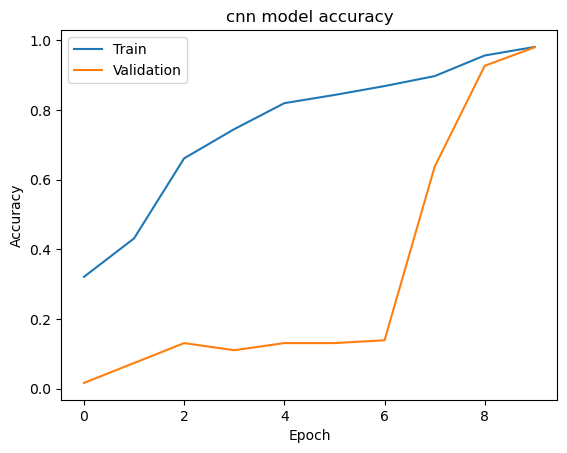

Training lstm model...
Epoch 1/10
31/31 [==============================] - 8s 166ms/step - loss: 0.5917 - accuracy: 0.3320 - val_loss: 0.7561 - val_accuracy: 0.0122
Epoch 2/10
31/31 [==============================] - 4s 143ms/step - loss: 0.5297 - accuracy: 0.4116 - val_loss: 0.7420 - val_accuracy: 0.0939
Epoch 3/10
31/31 [==============================] - 5s 147ms/step - loss: 0.4116 - accuracy: 0.6221 - val_loss: 0.7557 - val_accuracy: 0.0776
Epoch 4/10
31/31 [==============================] - 4s 143ms/step - loss: 0.3355 - accuracy: 0.7079 - val_loss: 0.6311 - val_accuracy: 0.1061
Epoch 5/10
31/31 [==============================] - 4s 141ms/step - loss: 0.2604 - accuracy: 0.8008 - val_loss: 0.3910 - val_accuracy: 0.7469
Epoch 6/10
31/31 [==============================] - 4s 141ms/step - loss: 0.1971 - accuracy: 0.8621 - val_loss: 0.4052 - val_accuracy: 0.7224
Epoch 7/10
31/31 [==============================] - 4s 141ms/step - loss: 0.1419 - accuracy: 0.8989 - val_loss: 0.1308 - val_

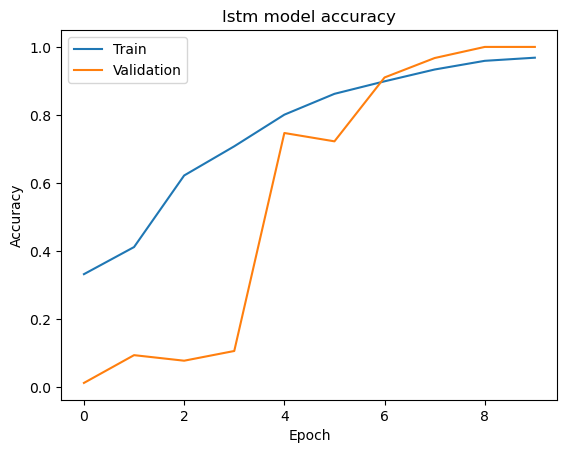

Training bilstm model...
Epoch 1/10
31/31 [==============================] - 11s 198ms/step - loss: 0.5758 - accuracy: 0.3258 - val_loss: 0.6855 - val_accuracy: 0.0694
Epoch 2/10
31/31 [==============================] - 5s 164ms/step - loss: 0.4950 - accuracy: 0.5138 - val_loss: 0.7299 - val_accuracy: 0.0980
Epoch 3/10
31/31 [==============================] - 5s 165ms/step - loss: 0.3629 - accuracy: 0.6731 - val_loss: 0.5600 - val_accuracy: 0.2653
Epoch 4/10
31/31 [==============================] - 5s 168ms/step - loss: 0.2612 - accuracy: 0.8008 - val_loss: 0.3134 - val_accuracy: 0.7551
Epoch 5/10
31/31 [==============================] - 5s 175ms/step - loss: 0.1754 - accuracy: 0.8846 - val_loss: 0.2305 - val_accuracy: 0.8857
Epoch 6/10
31/31 [==============================] - 5s 175ms/step - loss: 0.1243 - accuracy: 0.9224 - val_loss: 0.1385 - val_accuracy: 0.9347
Epoch 7/10
31/31 [==============================] - 6s 178ms/step - loss: 0.0888 - accuracy: 0.9469 - val_loss: 0.0588 - v

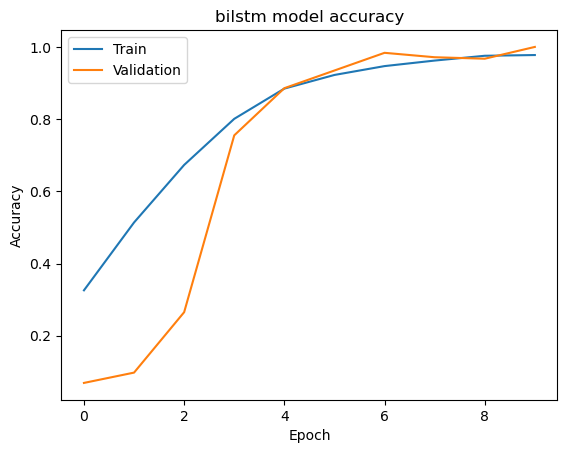

In [15]:
# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}


# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# UNDERSAMPLING DATASET AND ENCODING Y LABELS

In [6]:
#undersampling
ros = RandomUnderSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)






#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

# DEFINE THE NEURAL NETWORK MODELS WITH BEST PARAMS PASSED (UNDERSAMPLED)

In [7]:
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return rnn_model

def create_cnn(num_words=50000, embedding_size=128, filter_size=32, kernel_size=5, pool_size=3, dense_size=128, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm(num_words=50000, lstm_size=128, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



def create_bilstm(num_words=50000, lstm_size=128, embedding_size=128, dropout_rate=0.2, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# RUNNING MODELS ON UNDERSAMPLED DATASET AND PERFORMANCE ANALYSIS

2023-03-30 02:09:52.349957: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-30 02:09:52.710833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:09:52.712961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 02:09:52.714029: I tensorflow/core/com

Training rnn model...
Epoch 1/10


2023-03-30 02:09:53.009338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-30 02:09:53.045059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:09:53.046254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

38/38 [==============================] - 3s 45ms/step - loss: 0.5528 - accuracy: 0.3300 - val_loss: 0.9157 - val_accuracy: 0.0000e+00
Epoch 2/10
38/38 [==============================] - 2s 41ms/step - loss: 0.4693 - accuracy: 0.5617 - val_loss: 0.9151 - val_accuracy: 0.0000e+00
Epoch 3/10
38/38 [==============================] - 1s 39ms/step - loss: 0.3532 - accuracy: 0.7300 - val_loss: 0.9299 - val_accuracy: 0.0000e+00
Epoch 4/10
38/38 [==============================] - 2s 39ms/step - loss: 0.2405 - accuracy: 0.8242 - val_loss: 0.8638 - val_accuracy: 0.0000e+00
Epoch 5/10
38/38 [==============================] - 2s 41ms/step - loss: 0.1576 - accuracy: 0.8908 - val_loss: 0.7701 - val_accuracy: 0.2433
Epoch 6/10
38/38 [==============================] - 2s 40ms/step - loss: 0.1030 - accuracy: 0.9375 - val_loss: 0.7610 - val_accuracy: 0.3333
Epoch 7/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0694 - accuracy: 0.9617 - val_loss: 0.7098 - val_accuracy: 0.4700
Epoch 8/

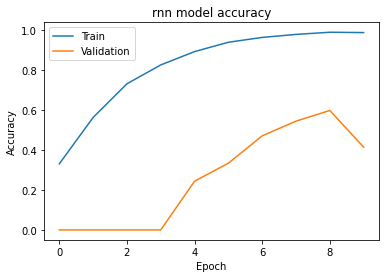

Training cnn model...
Epoch 1/10
38/38 [==============================] - 5s 112ms/step - loss: 0.5757 - accuracy: 0.3133 - val_loss: 1.0047 - val_accuracy: 0.0000e+00
Epoch 2/10
38/38 [==============================] - 4s 110ms/step - loss: 0.5301 - accuracy: 0.3300 - val_loss: 0.9589 - val_accuracy: 0.0000e+00
Epoch 3/10
38/38 [==============================] - 4s 109ms/step - loss: 0.4894 - accuracy: 0.4875 - val_loss: 0.9625 - val_accuracy: 0.0000e+00
Epoch 4/10
38/38 [==============================] - 4s 110ms/step - loss: 0.3797 - accuracy: 0.6775 - val_loss: 0.8861 - val_accuracy: 0.0000e+00
Epoch 5/10
38/38 [==============================] - 4s 107ms/step - loss: 0.3039 - accuracy: 0.7742 - val_loss: 0.9231 - val_accuracy: 0.0000e+00
Epoch 6/10
38/38 [==============================] - 4s 108ms/step - loss: 0.2422 - accuracy: 0.8175 - val_loss: 0.8968 - val_accuracy: 0.0000e+00
Epoch 7/10
38/38 [==============================] - 4s 109ms/step - loss: 0.1955 - accuracy: 0.8483 - 

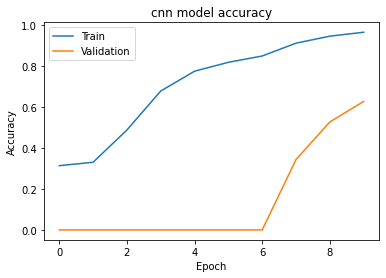

Training lstm model...
Epoch 1/10


2023-03-30 02:10:52.591102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:10:52.592797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 02:10:52.594044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 [==============================] - ETA: 0s - loss: 0.5727 - accuracy: 0.3250

2023-03-30 02:10:59.225654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:10:59.226732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 02:10:59.227657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 [==============================] - 7s 151ms/step - loss: 0.5727 - accuracy: 0.3250 - val_loss: 0.9039 - val_accuracy: 0.0000e+00
Epoch 2/10
38/38 [==============================] - 6s 146ms/step - loss: 0.5071 - accuracy: 0.4525 - val_loss: 0.9121 - val_accuracy: 0.0000e+00
Epoch 3/10
38/38 [==============================] - 6s 146ms/step - loss: 0.3992 - accuracy: 0.6300 - val_loss: 0.9440 - val_accuracy: 0.0000e+00
Epoch 4/10
38/38 [==============================] - 6s 145ms/step - loss: 0.3087 - accuracy: 0.7708 - val_loss: 0.8779 - val_accuracy: 0.0000e+00
Epoch 5/10
38/38 [==============================] - 5s 144ms/step - loss: 0.2416 - accuracy: 0.8217 - val_loss: 0.9292 - val_accuracy: 0.0000e+00
Epoch 6/10
38/38 [==============================] - 6s 146ms/step - loss: 0.1858 - accuracy: 0.8708 - val_loss: 0.6312 - val_accuracy: 0.4100
Epoch 7/10
38/38 [==============================] - 6s 149ms/step - loss: 0.1298 - accuracy: 0.9225 - val_loss: 0.5192 - val_accuracy: 0.64

2023-03-30 02:11:49.706743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:11:49.708296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 02:11:49.710000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 1s 19ms/step
lstm model confusion matrix:
[[127   1  11   0]
 [ 19 197  32   1]
 [ 27  43 229   3]
 [ 11   8  11  80]]
lstm model classification report:
              precision    recall  f1-score   support

           0       0.69      0.91      0.79       139
           1       0.79      0.79      0.79       249
           2       0.81      0.76      0.78       302
           3       0.95      0.73      0.82       110

    accuracy                           0.79       800
   macro avg       0.81      0.80      0.80       800
weighted avg       0.80      0.79      0.79       800

lstm model accuracy: 0.7913
lstm model precision: 0.8107
lstm model recall: 0.7976


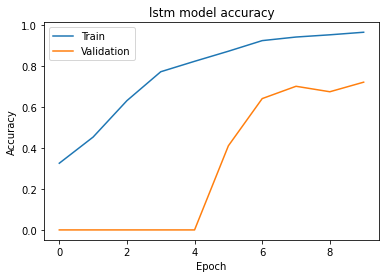

Training bilstm model...
Epoch 1/10


2023-03-30 02:11:50.609918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:11:50.611464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 02:11:50.612791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 [==============================] - ETA: 0s - loss: 0.5563 - accuracy: 0.3333

2023-03-30 02:12:00.027978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:12:00.029160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 02:12:00.030345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 [==============================] - 10s 207ms/step - loss: 0.5563 - accuracy: 0.3333 - val_loss: 1.0141 - val_accuracy: 0.0000e+00
Epoch 2/10
38/38 [==============================] - 8s 200ms/step - loss: 0.4632 - accuracy: 0.5375 - val_loss: 0.9329 - val_accuracy: 0.0000e+00
Epoch 3/10
38/38 [==============================] - 8s 208ms/step - loss: 0.3510 - accuracy: 0.7167 - val_loss: 0.8705 - val_accuracy: 0.0000e+00
Epoch 4/10
38/38 [==============================] - 8s 213ms/step - loss: 0.2543 - accuracy: 0.7833 - val_loss: 0.8724 - val_accuracy: 0.0000e+00
Epoch 5/10
38/38 [==============================] - 7s 191ms/step - loss: 0.1837 - accuracy: 0.8642 - val_loss: 0.7537 - val_accuracy: 0.1900
Epoch 6/10
38/38 [==============================] - 7s 191ms/step - loss: 0.1248 - accuracy: 0.9150 - val_loss: 0.7662 - val_accuracy: 0.4067
Epoch 7/10
38/38 [==============================] - 7s 193ms/step - loss: 0.0969 - accuracy: 0.9417 - val_loss: 0.5685 - val_accuracy: 0.6100


2023-03-30 02:13:08.333300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:13:08.335886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 02:13:08.337074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 1s 24ms/step
bilstm model confusion matrix:
[[121   8   8   2]
 [ 14 207  25   3]
 [ 22  51 228   1]
 [ 13   7  10  80]]
bilstm model classification report:
              precision    recall  f1-score   support

           0       0.71      0.87      0.78       139
           1       0.76      0.83      0.79       249
           2       0.84      0.75      0.80       302
           3       0.93      0.73      0.82       110

    accuracy                           0.80       800
   macro avg       0.81      0.80      0.80       800
weighted avg       0.81      0.80      0.80       800

bilstm model accuracy: 0.7950
bilstm model precision: 0.8104
bilstm model recall: 0.7960


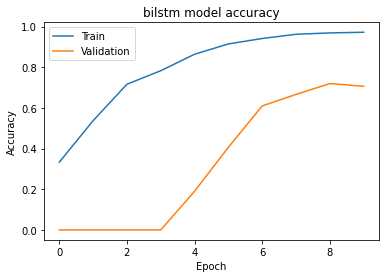

In [8]:
# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}


# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()